In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore")
from yellowbrick.regressor import PredictionError

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, max_error
from yellowbrick.regressor import PredictionError
import os
import pandas as pd
import matplotlib.pyplot as plt


class DistrictAnalysis:
    def __init__(self, csv_file,year):
        self.df_main = pd.read_csv(csv_file)
        self.year = year
        self.plot_folder = "/home/ravi/myfolder/project/artpark/dengue data/plots"
        os.makedirs(self.plot_folder, exist_ok=True)

    def pop_mean(self):
        self.df_main = self.df_main[self.df_main['Year'].isin([2017,2018,2019,2022])]
        self.df_main['Case_Count'] = self.df_main['Case_Count'] / (self.df_main['Population'] / 1000000)
        return self.df_main

    def process_district_data(self, district_name):
        df_c = self.df_main.loc[self.df_main['District'] == district_name]
        df_c = df_c.dropna().reset_index(drop=True)
        return df_c

    def split_train_test(self, df):
        train_data = df[~(df['Year'].isin([self.year]))]
        #train_data = train_data[train_data['Record_Week'] < 46]

        test_data = df[df['Year'] == self.year]
        #test_data = test_data[test_data['Record_Week'] < 46]

        # Extracting features (X) and target variable (Y) for train and test sets
        x_train = train_data[["2m_Temperature", "2m_Dewpoint_Temperature", "Total_Precipitation"]]
        y_train = train_data["Case_Count"]

        x_test = test_data[["2m_Temperature", "2m_Dewpoint_Temperature", "Total_Precipitation"]]
        y_test = test_data["Case_Count"]

        # Standardize features
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)
        
        return x_train_scaled, x_test_scaled, y_train, y_test

    def ridge_regression(self, x_train, x_test, y_train, y_test):
        ridge_regressor = Ridge(random_state=42)
        param_grid = {
            'alpha': [0.0001, 0.001, 0.01,0.1,0.2,0.5,1,2,5,10]  
        }
        grid_search = GridSearchCV(estimator=ridge_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        best_ridge_regressor = grid_search.best_estimator_
        y_pred = best_ridge_regressor.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse**0.5
        return y_pred,rmse

    
    
    def calculate_error_metrics(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        explained_variance = explained_variance_score(y_test, y_pred)
        median_ae = median_absolute_error(y_test, y_pred)
        max_err = max_error(y_test, y_pred)
        error_metrics = pd.DataFrame({
            'Error Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)',
                             'R-squared (R2)', 'Explained Variance Score',
                             'Median Absolute Error', 'Maximum Error'],
            'Value': [mse, mae, r2, explained_variance, median_ae, max_err]
        })
        return error_metrics
    
    def plot_prediction(self, district_name,rmse, y_pred, y_test):
        mse = mean_squared_error(y_test, y_pred)

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(y_test)), y_test, color='blue', label='Actual')
        plt.plot(range(len(y_pred)), y_pred, color='red', marker='o', linestyle='-',
                 linewidth=2, markersize=6, label='Predicted')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.title(f'Actual vs Predicted Values for {district_name}')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.text(0.02, 0.88, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, color='red',
                 weight='bold', verticalalignment='top', fontsize=12)

        # Save the plot
        district_plot_folder = os.path.join(self.plot_folder, district_name, 'Ridge')
        os.makedirs(district_plot_folder, exist_ok=True)  # Create the folder if it doesn't exist
        plt.savefig(os.path.join(district_plot_folder, f'{self.year}prediction_plot.png'))

        plt.show()

    def plot_yellowbrick_prediction_error(self, district_name, x_train, y_train, x_test, y_test):
        visualizer = PredictionError(Lasso(random_state=42))
        visualizer.fit(x_train, y_train)
        visualizer.score(x_test, y_test)
        
        plt.title(f'Prediction Error for {district_name}')
        visualizer.poof()
        
    def plot_yellowbrick_residuals(self, district_name, x_train, y_train, x_test, y_test):
        rf_regressor = RandomForestRegressor(random_state=42)
        rf_regressor.fit(x_train, y_train)
        y_pred = rf_regressor.predict(x_test)

        visualizer = ResidualsPlot(rf_regressor)
        visualizer.score(x_test, y_test)

        plt.title(f'Residuals Plot for {district_name}')
        visualizer.show()
        


    def analyze_districts(self):
        unique_districts = self.df_main['District'].unique()
        all_district_data = []
        for district_name in unique_districts:
            print(f"Analyzing District: {district_name}")
            district_data = self.process_district_data(district_name)
            x_train, x_test, y_train, y_test = self.split_train_test(district_data)
            #self.plot_yellowbrick_prediction_error(district_name, x_train, y_train, x_test, y_test)
            y_pred_svr, rmse_svr = self.ridge_regression(x_train, x_test, y_train, y_test)
            performance = "Good" if rmse_svr < 2 else "Bad"
    
            # Create a dictionary for each district's data
            district_data = {
                "district": district_name,
                f"{self.year}_rmse": rmse_svr,
                f"{self.year}_performance": performance
            }
    
            all_district_data.append(district_data)
            final_df = pd.DataFrame(all_district_data)
            self.plot_prediction(district_name,rmse_svr, y_pred_svr, y_test)
            print("=" * 100)
        return final_df

    





Analyzing District: BAGALKOTE


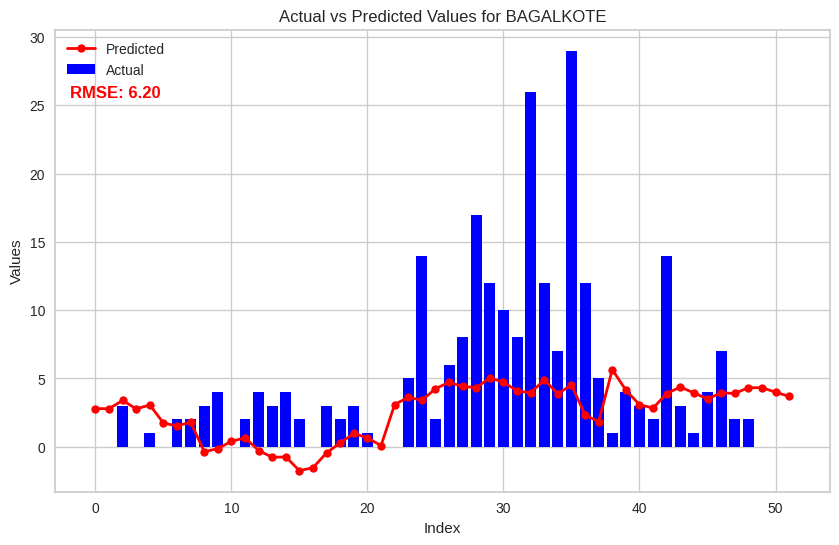

Analyzing District: BALLARI


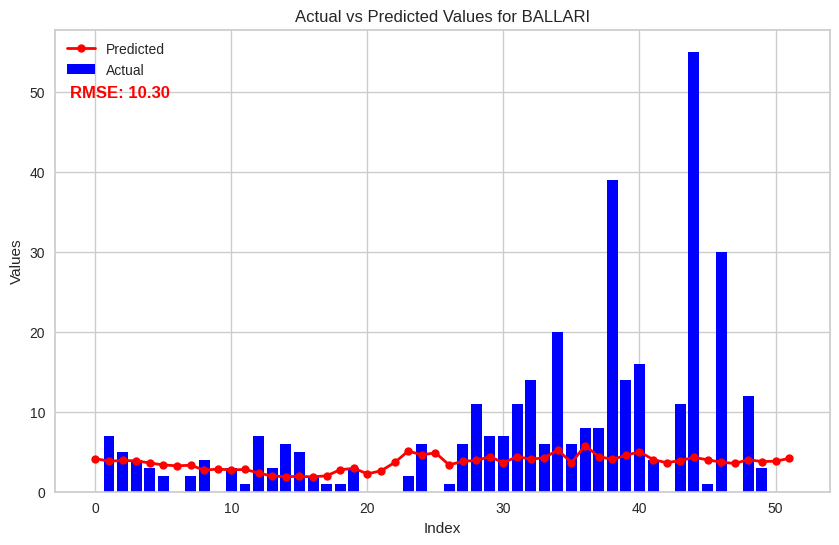

Analyzing District: BELAGAVI


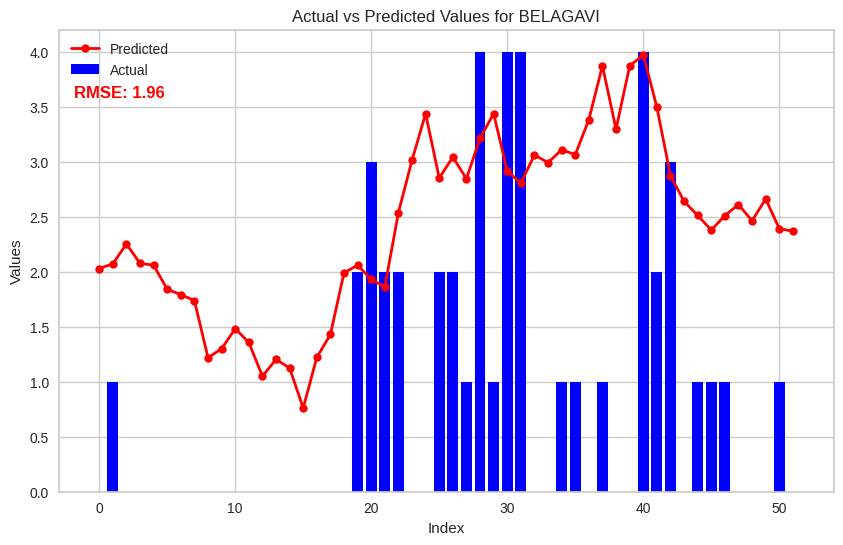

Analyzing District: BENGALURU RURAL


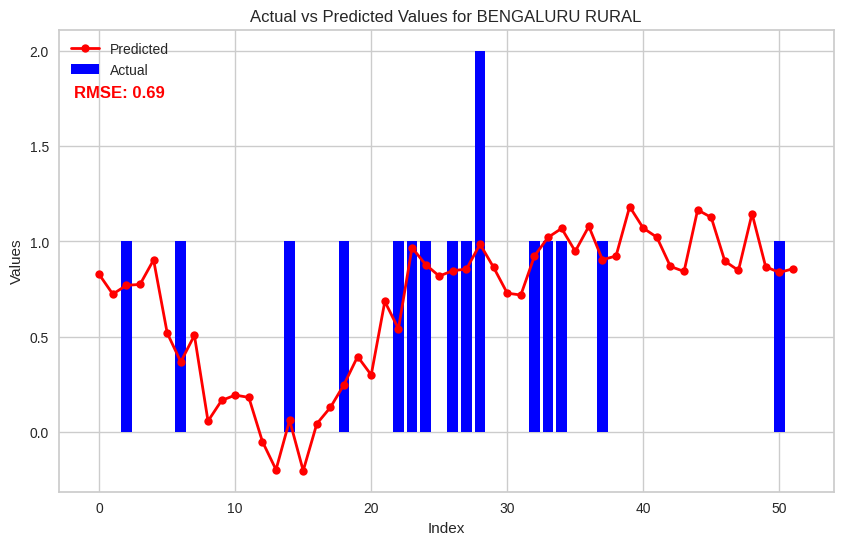

Analyzing District: BENGALURU URBAN


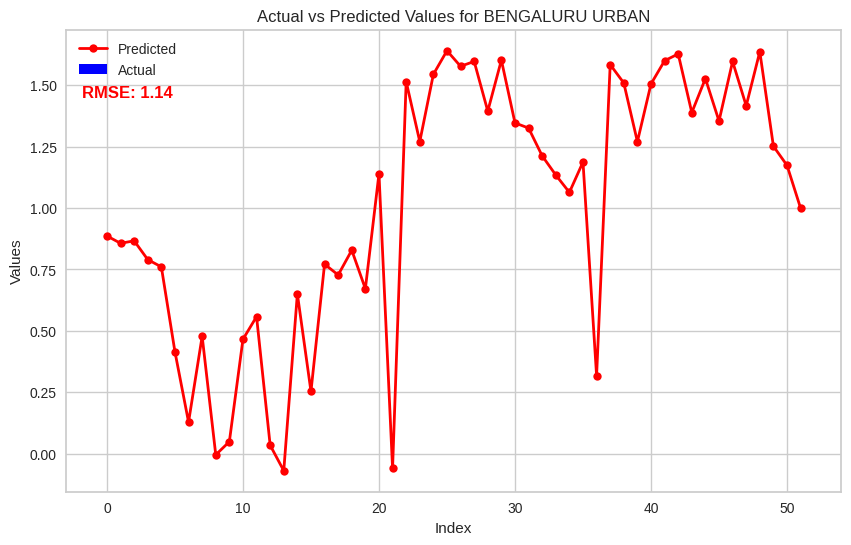

Analyzing District: BIDAR


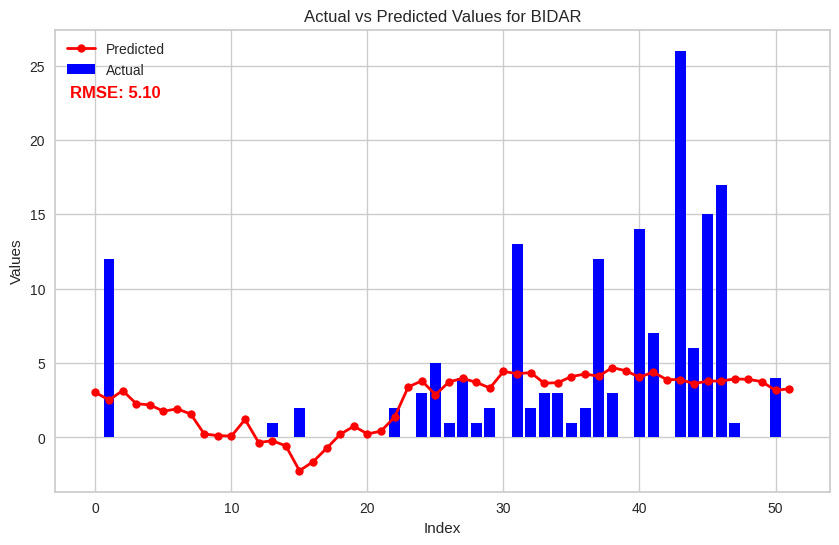

Analyzing District: CHAMARAJANAGARA


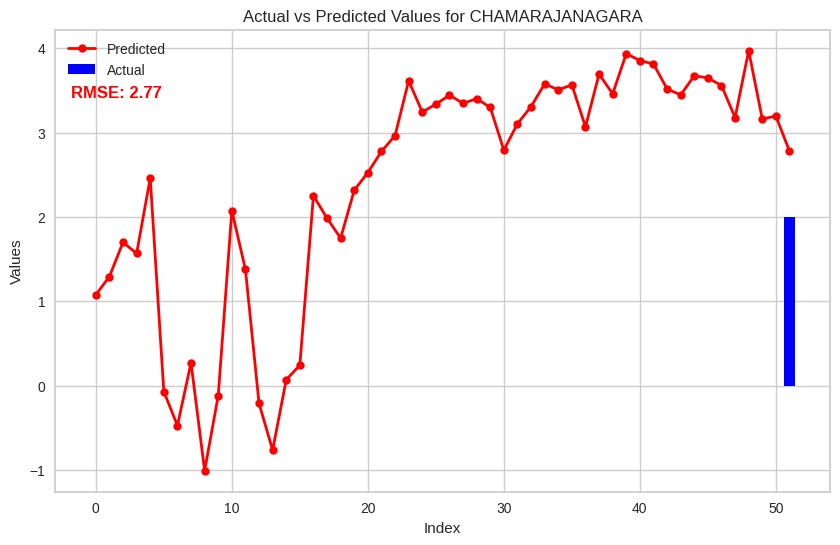

Analyzing District: CHIKKABALLAPURA


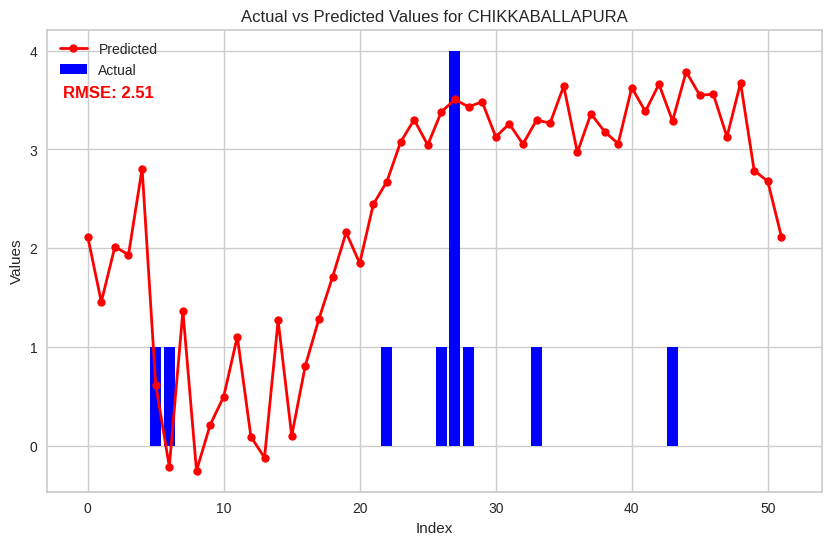

Analyzing District: CHIKKAMAGALURU


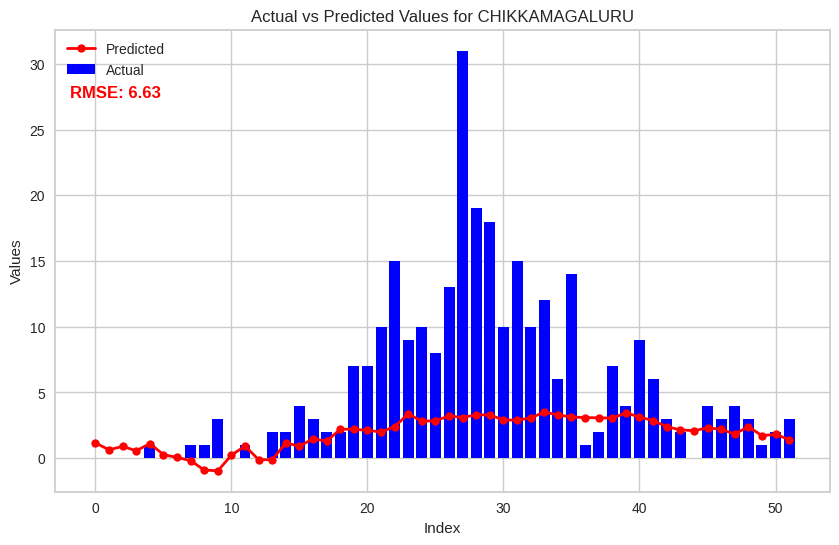

Analyzing District: CHITRADURGA


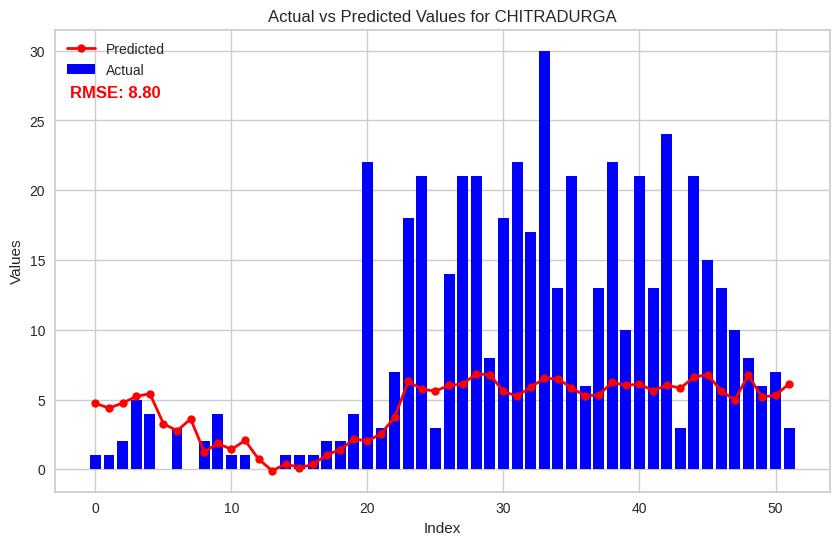

Analyzing District: DAKSHINA KANNADA


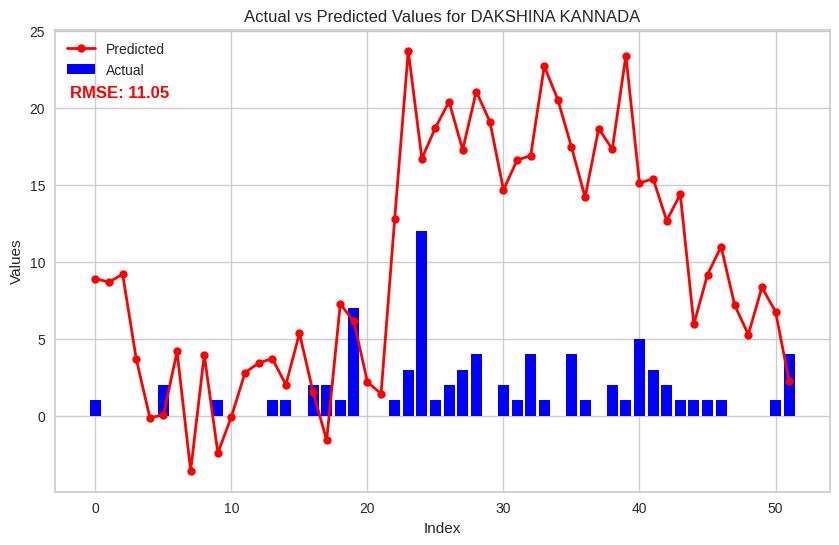

Analyzing District: DAVANGERE


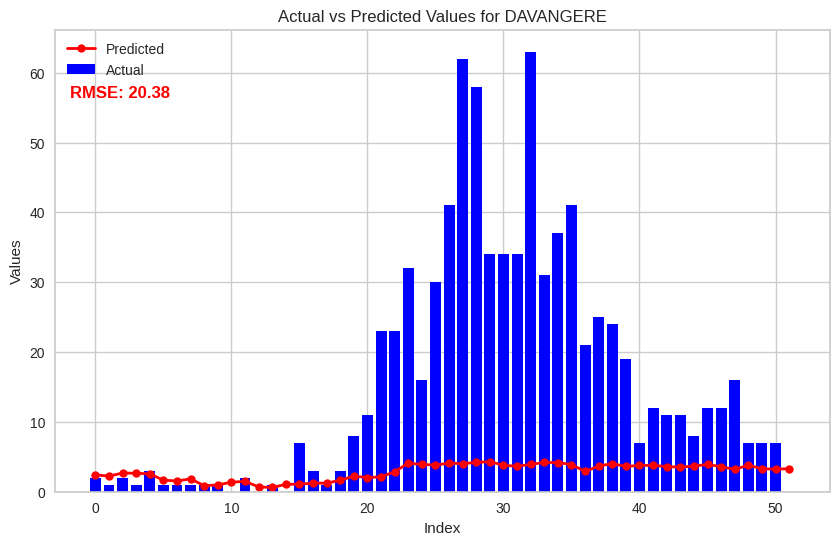

Analyzing District: DHARWAD


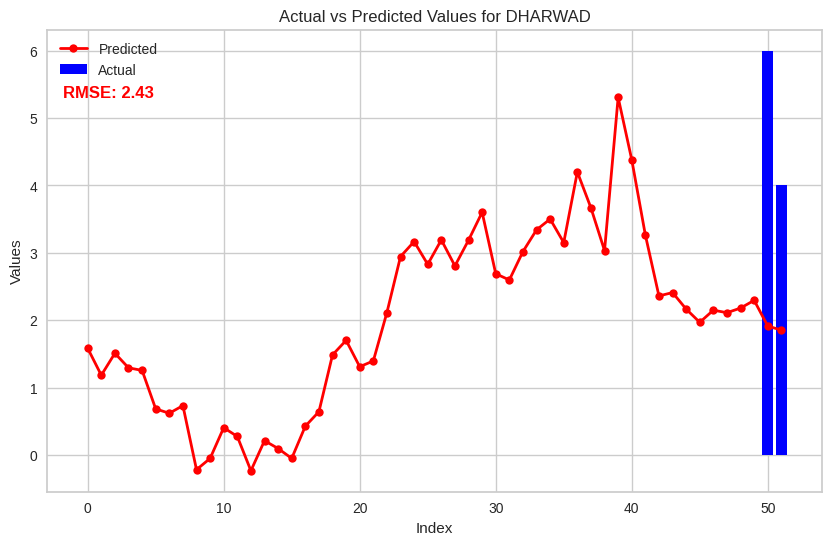

Analyzing District: GADAG


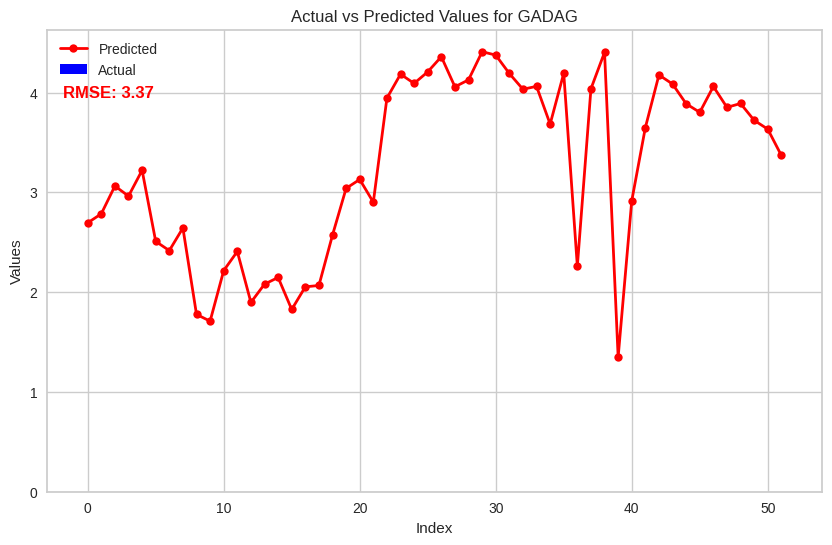

Analyzing District: HASSAN


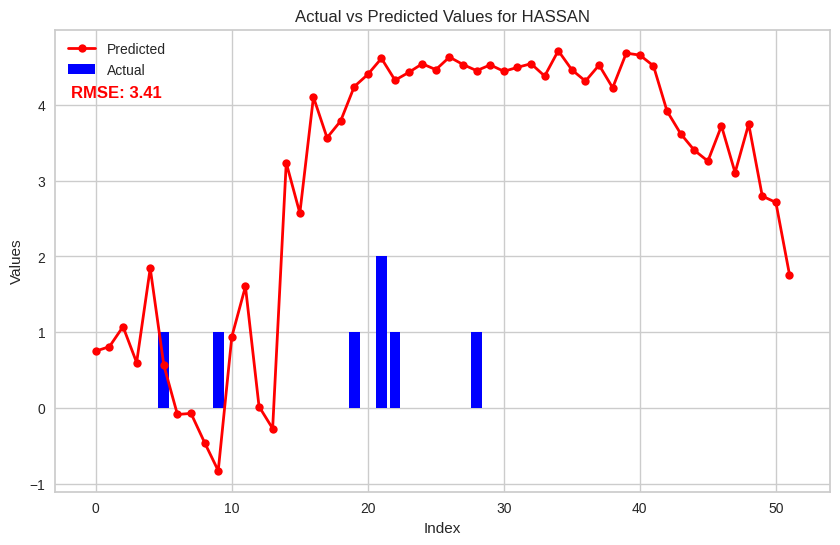

Analyzing District: HAVERI


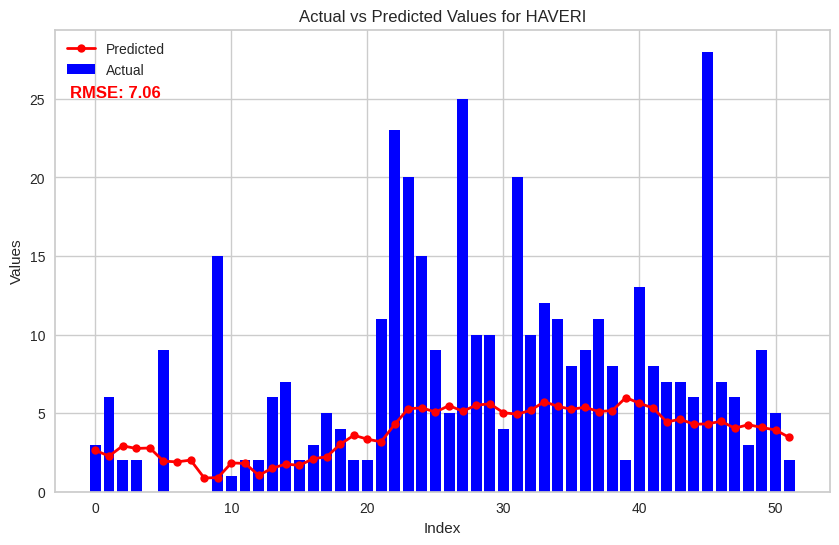

Analyzing District: KALABURAGI


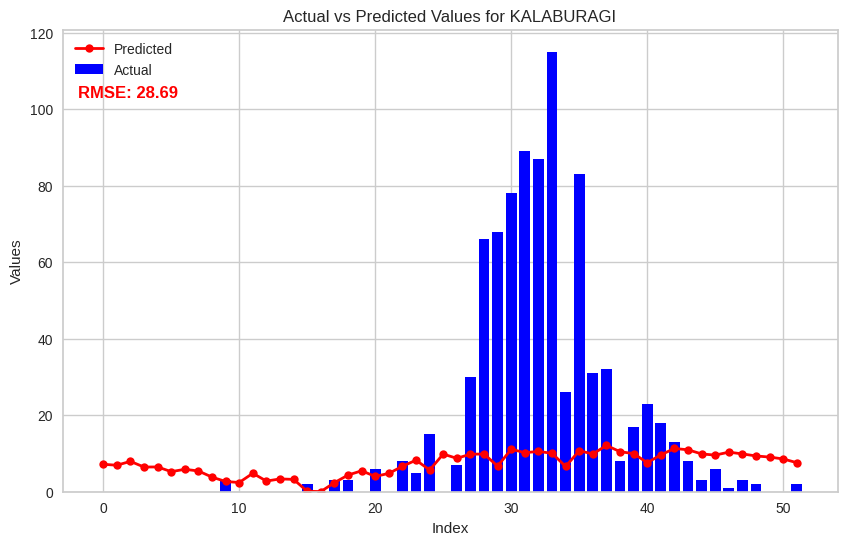

Analyzing District: KODAGU


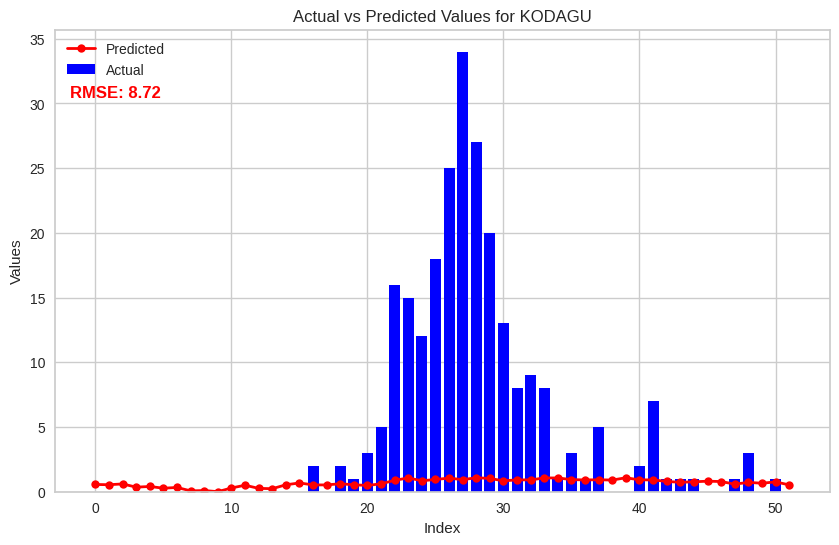

Analyzing District: KOLAR


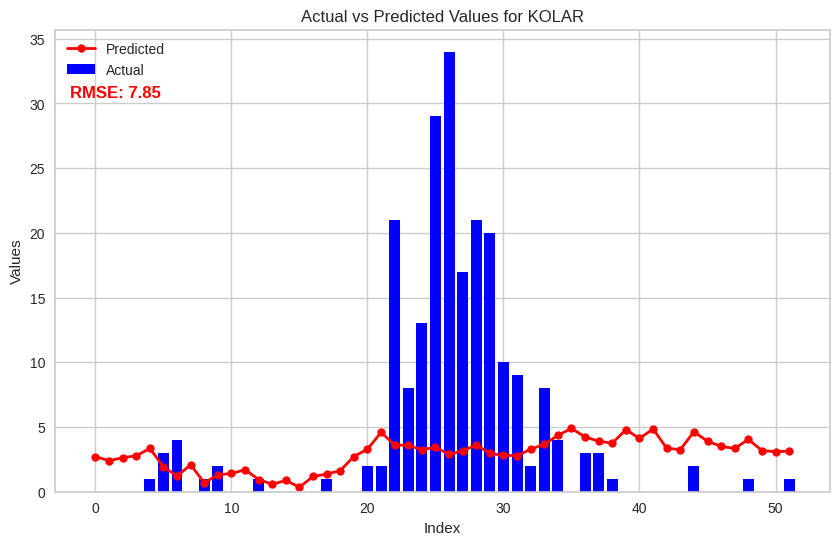

Analyzing District: KOPPAL


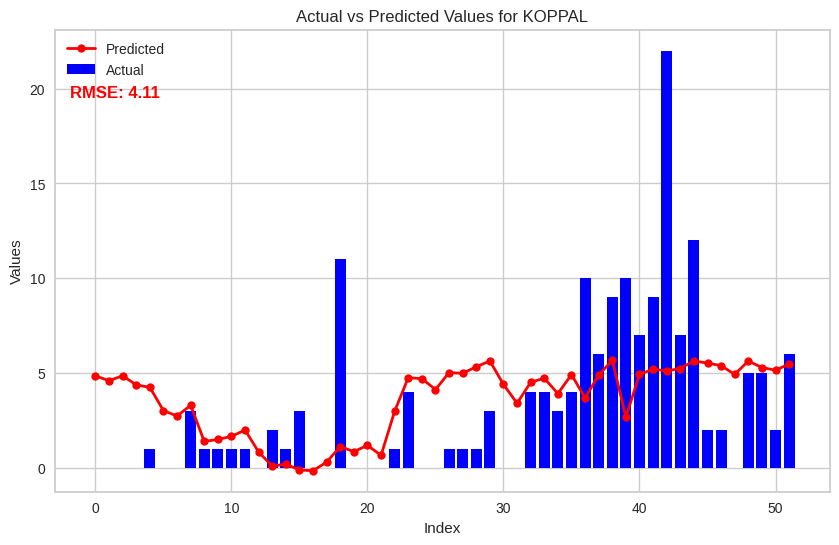

Analyzing District: MANDYA


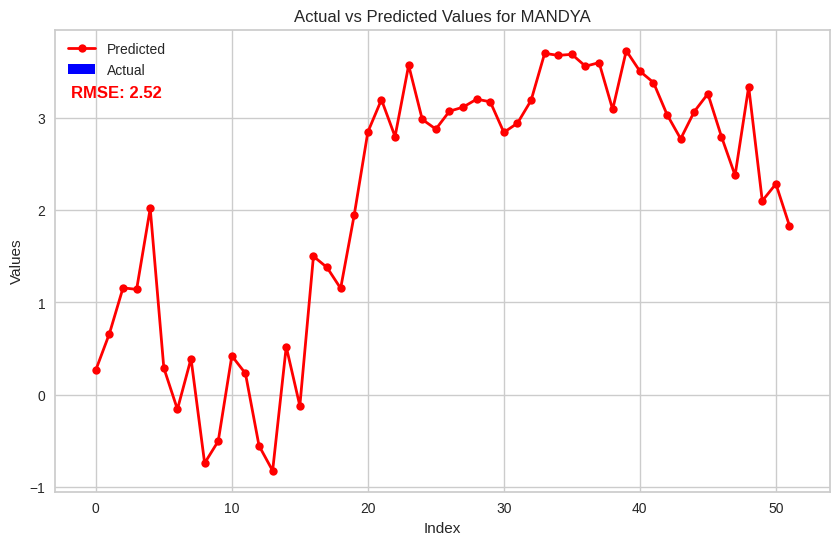

Analyzing District: MYSURU


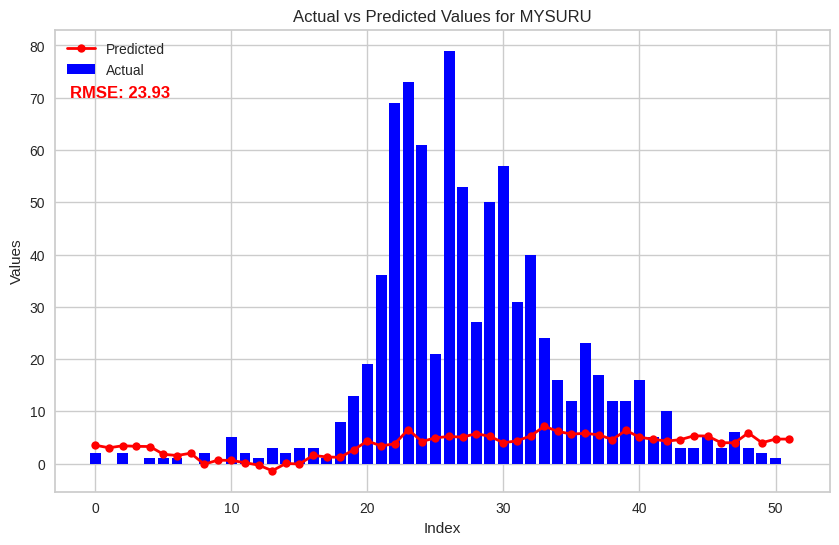

Analyzing District: RAICHUR


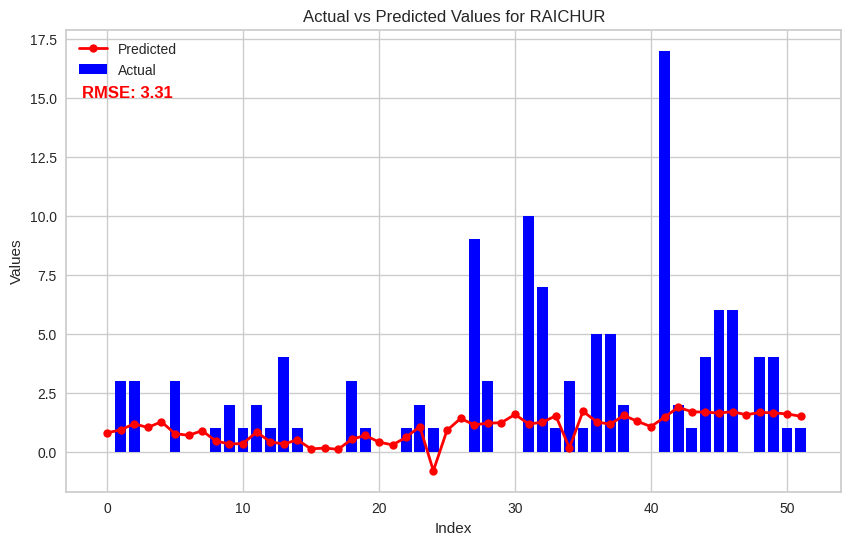

Analyzing District: RAMANAGARA


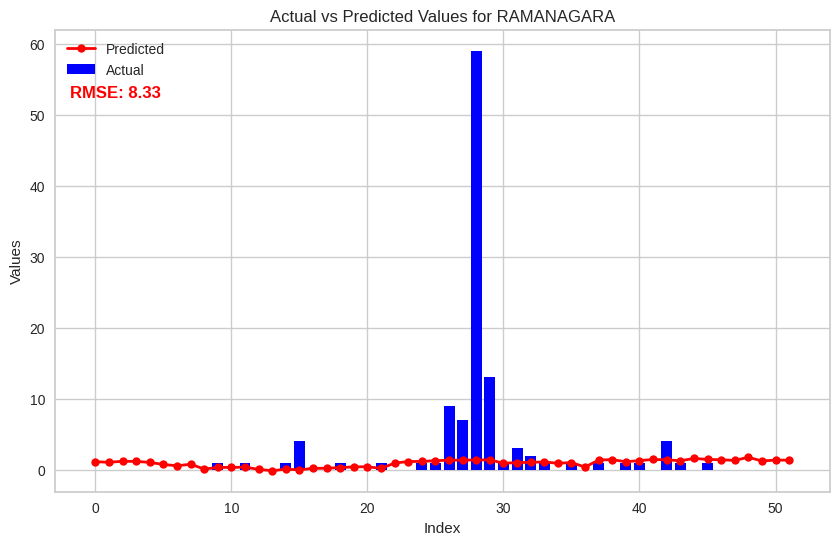

Analyzing District: SHIVAMOGGA


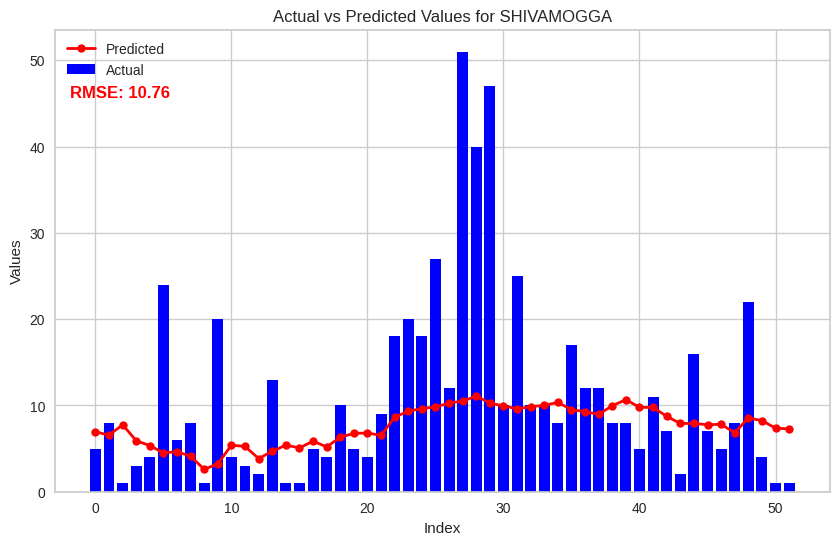

Analyzing District: TUMAKURU


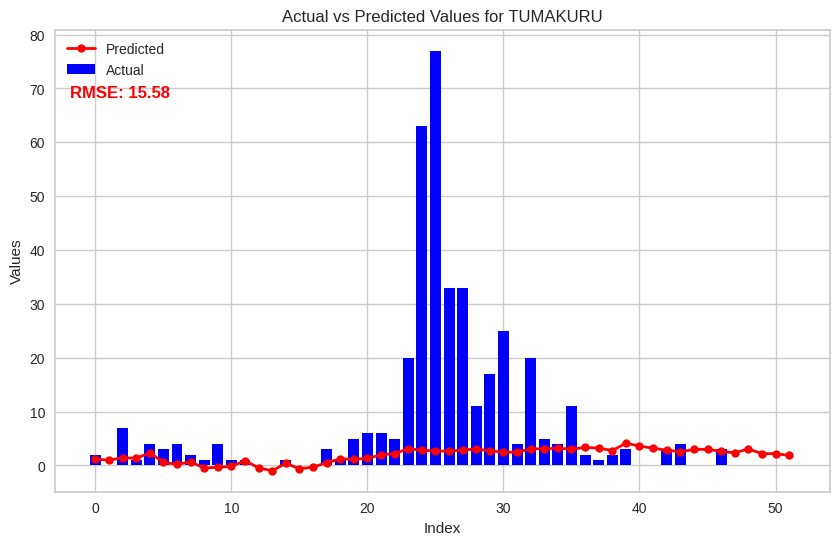

Analyzing District: UDUPI


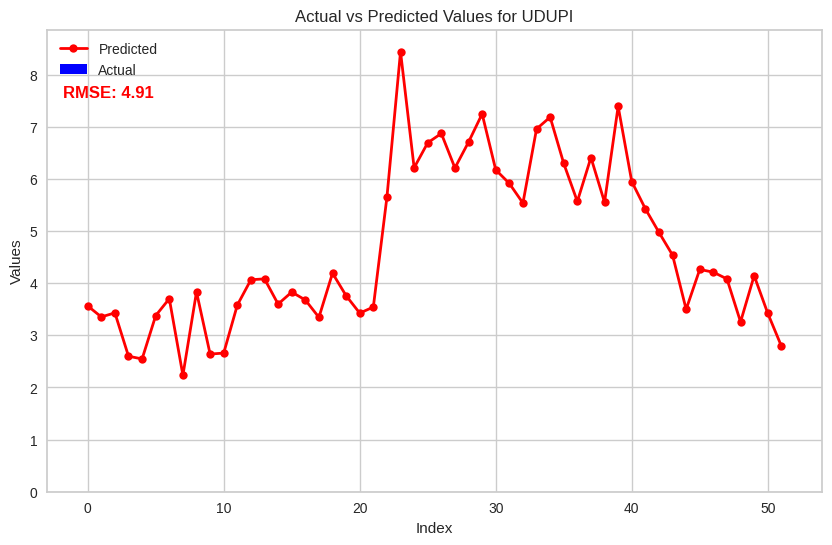

Analyzing District: UTTARA KANNADA


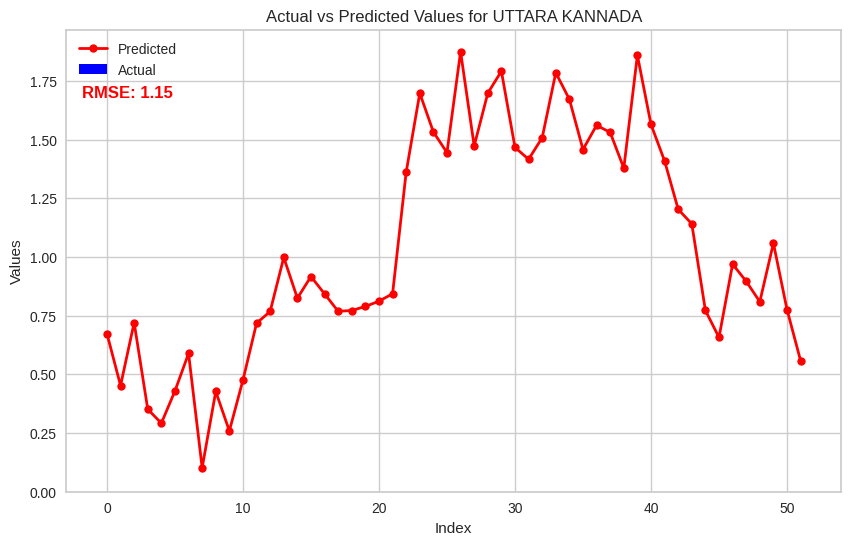

Analyzing District: VIJAYANAGAR


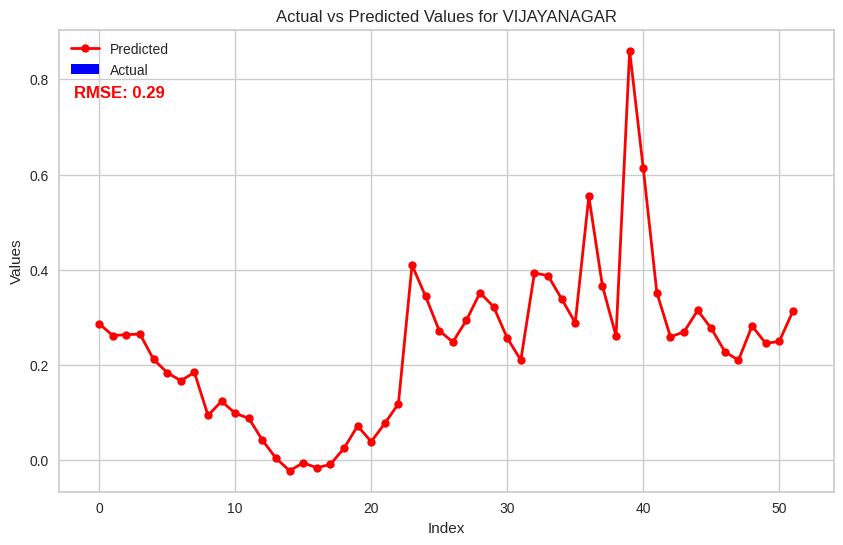

Analyzing District: VIJAYAPURA


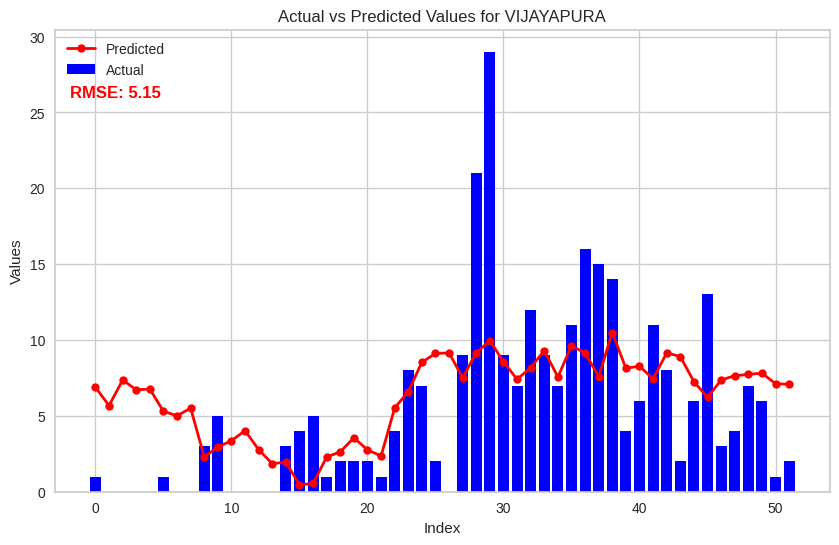

Analyzing District: YADGIR


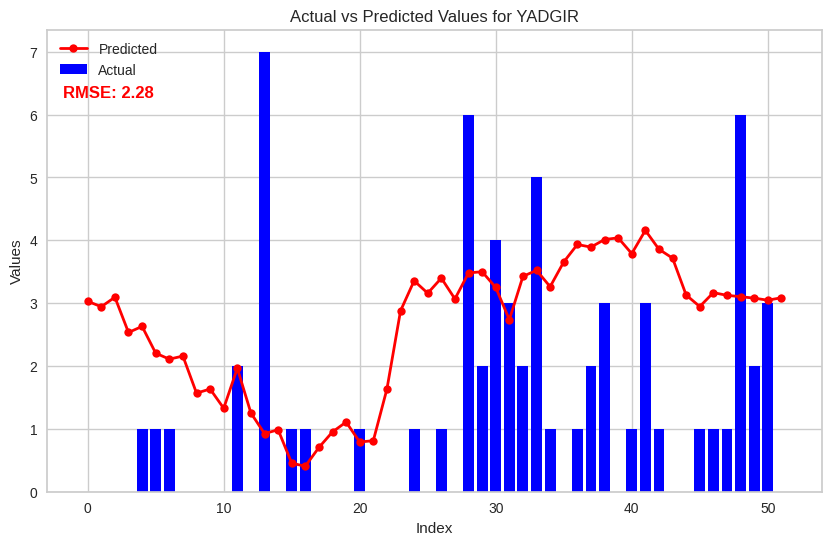

In [25]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2017)
df_2017 = district_analysis.analyze_districts()

Analyzing District: BAGALKOTE


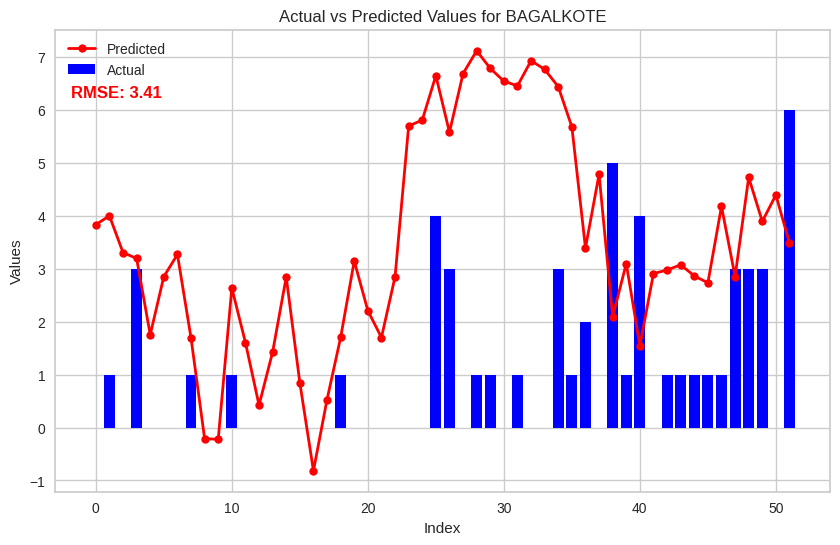

Analyzing District: BALLARI


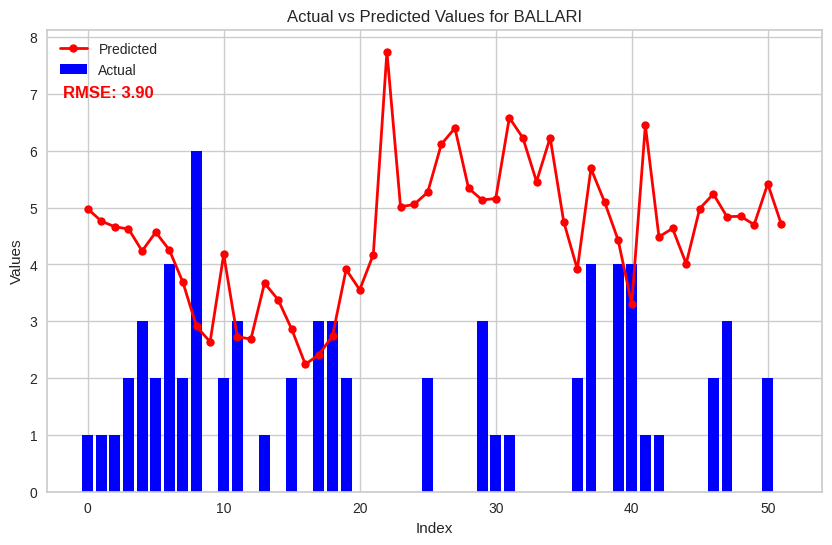

Analyzing District: BELAGAVI


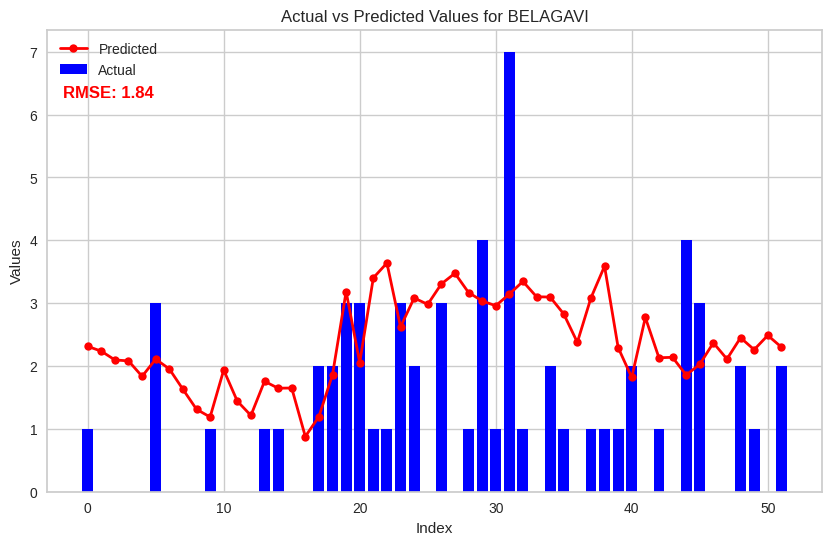

Analyzing District: BENGALURU RURAL


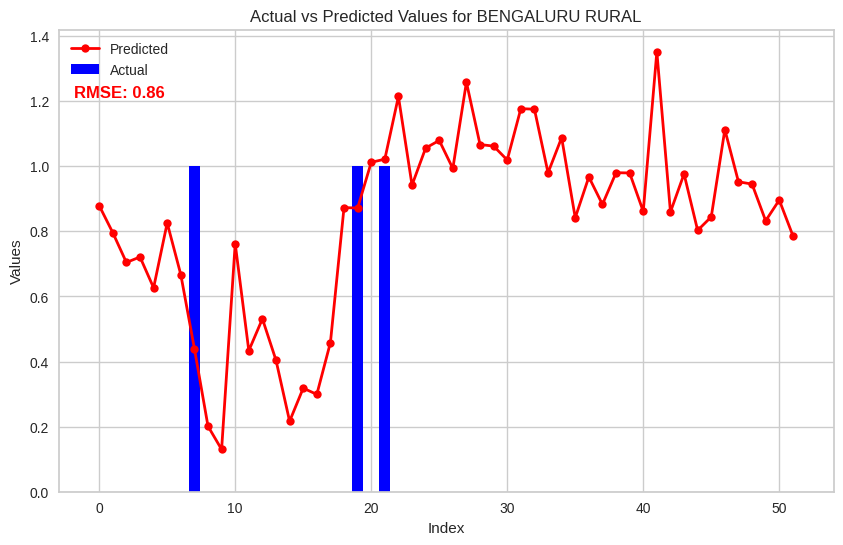

Analyzing District: BENGALURU URBAN


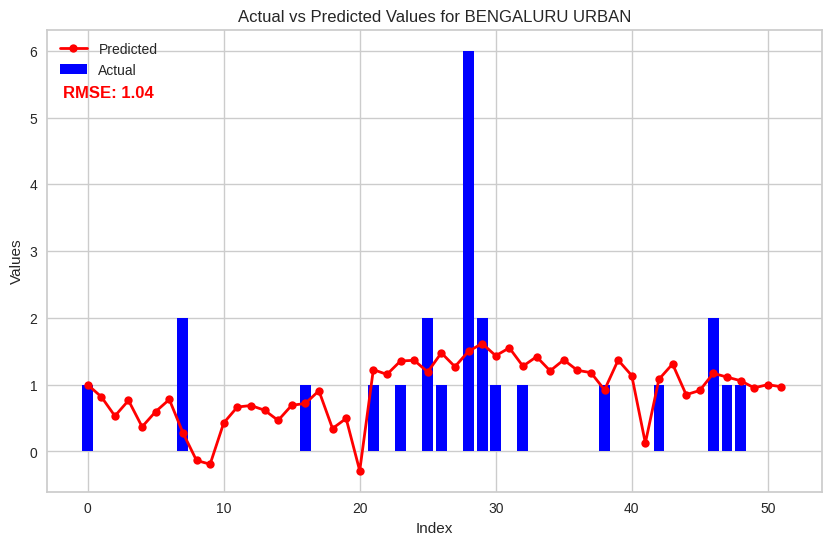

Analyzing District: BIDAR


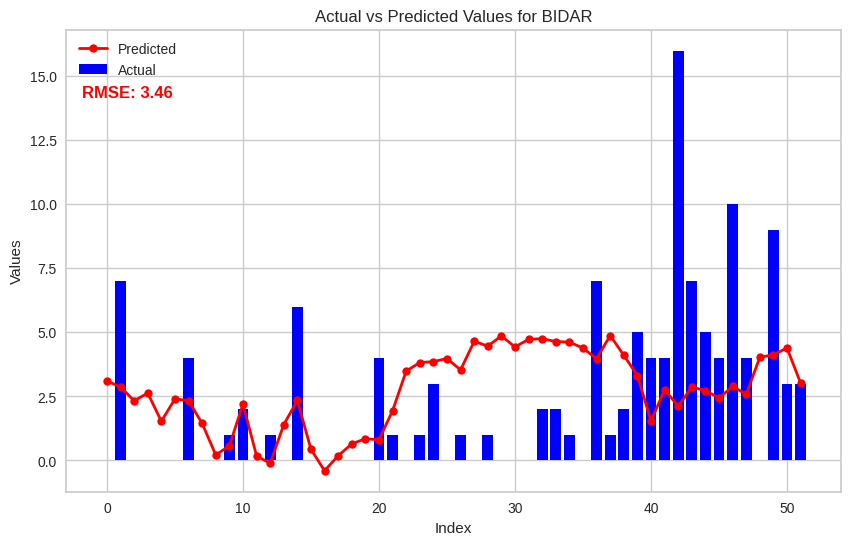

Analyzing District: CHAMARAJANAGARA


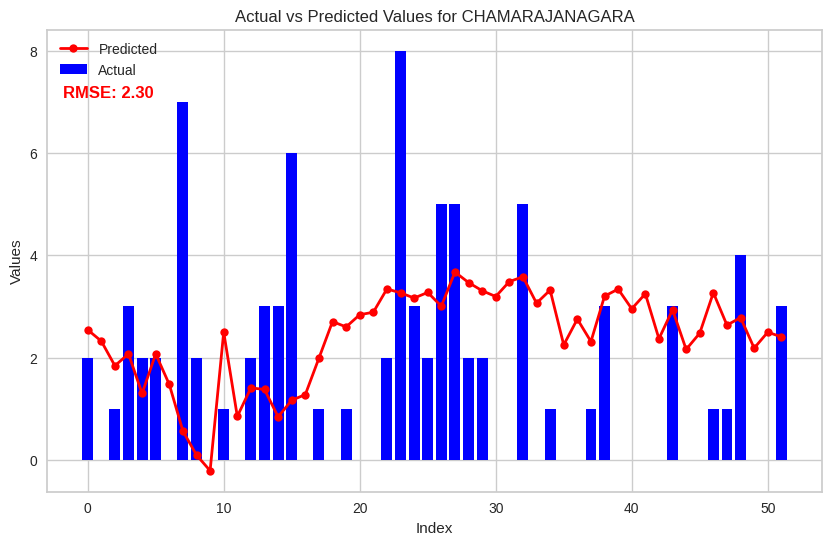

Analyzing District: CHIKKABALLAPURA


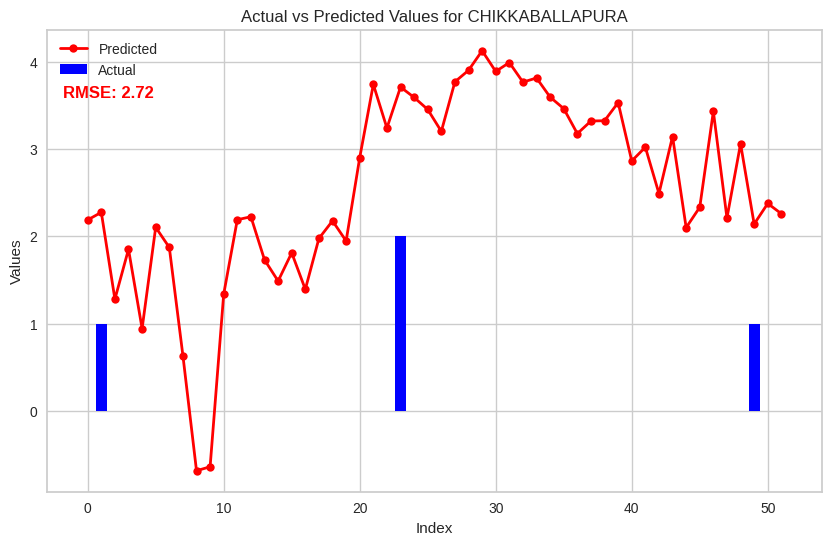

Analyzing District: CHIKKAMAGALURU


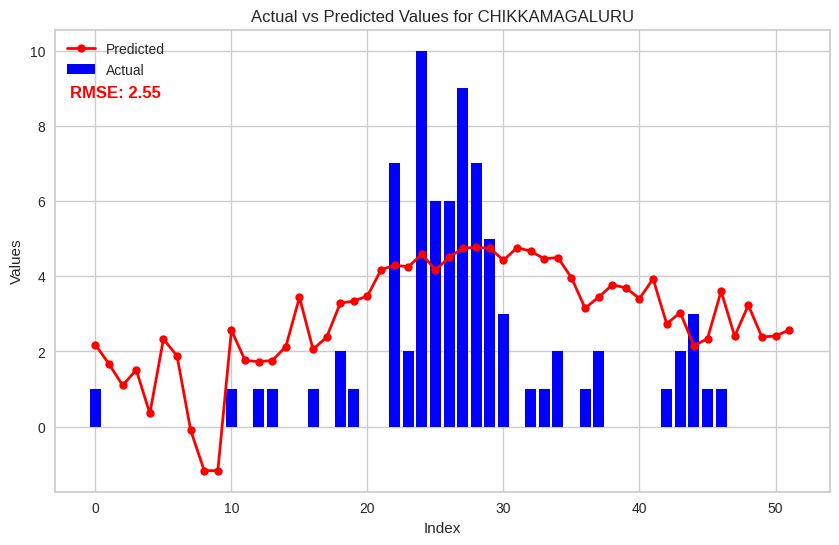

Analyzing District: CHITRADURGA


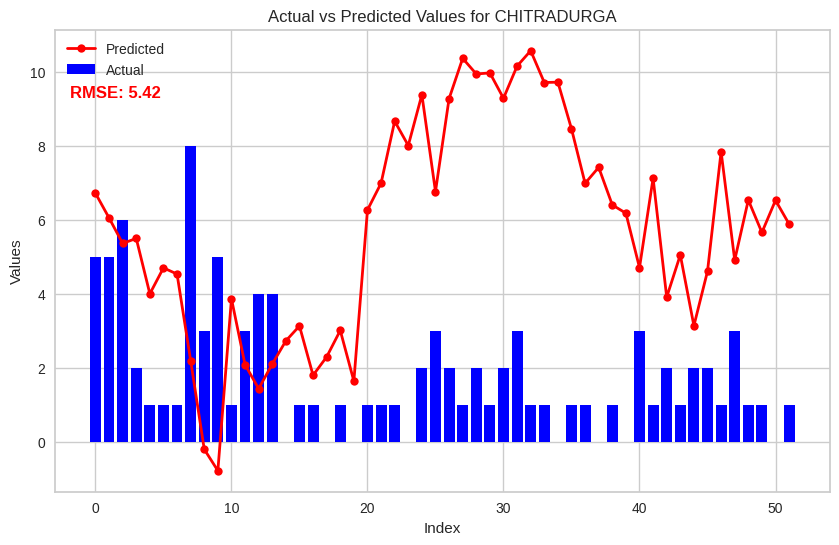

Analyzing District: DAKSHINA KANNADA


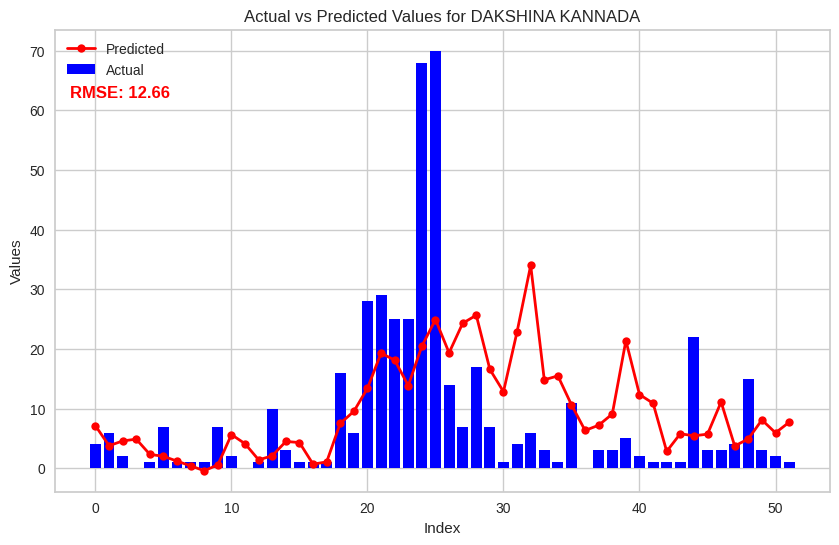

Analyzing District: DAVANGERE


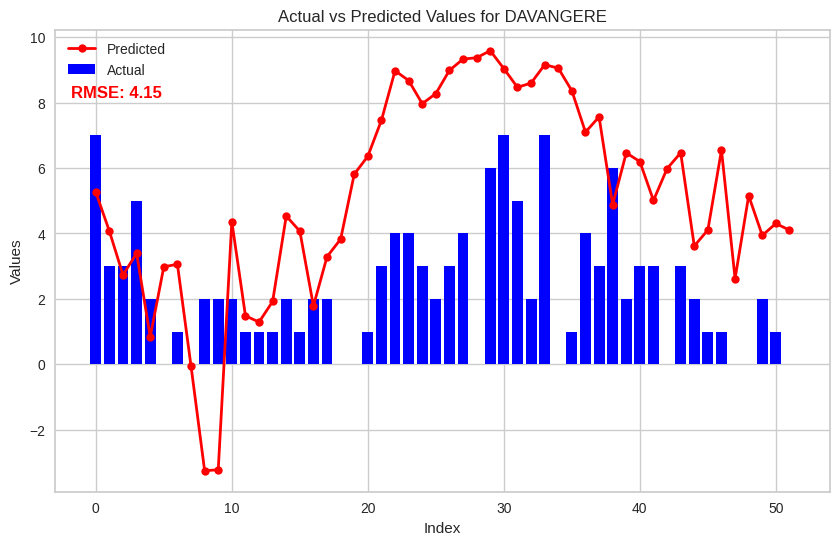

Analyzing District: DHARWAD


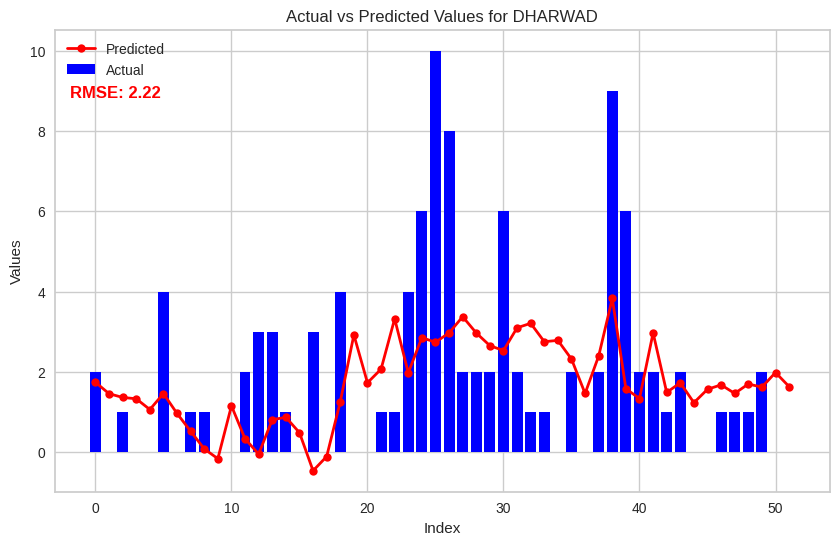

Analyzing District: GADAG


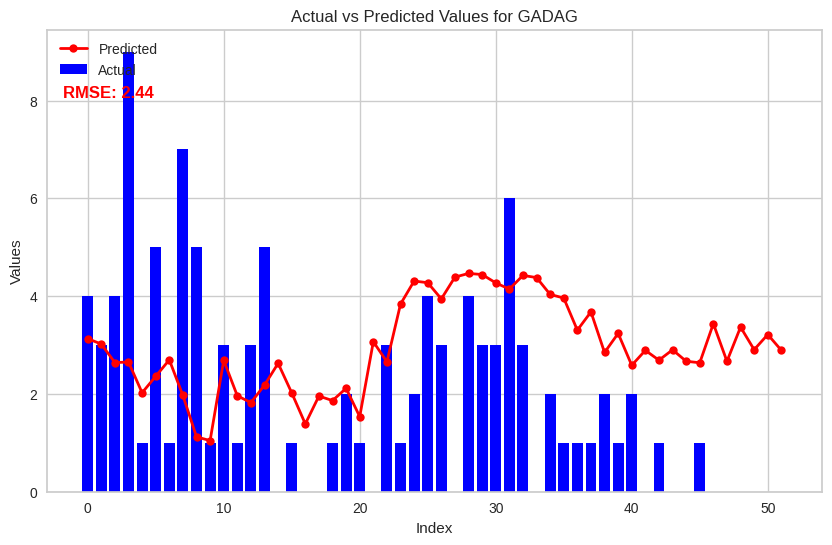

Analyzing District: HASSAN


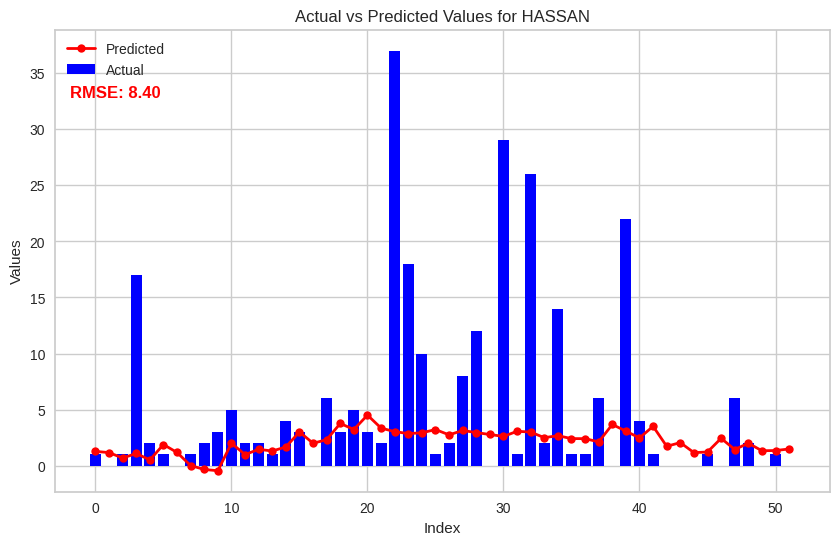

Analyzing District: HAVERI


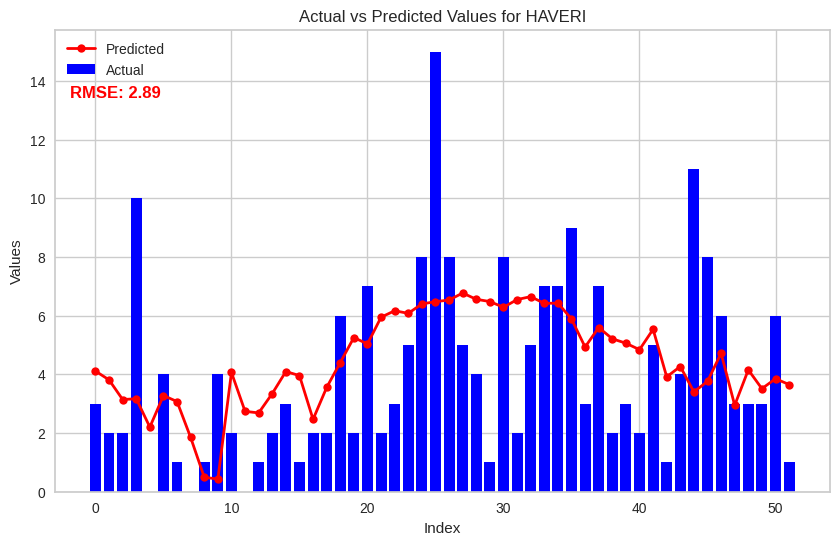

Analyzing District: KALABURAGI


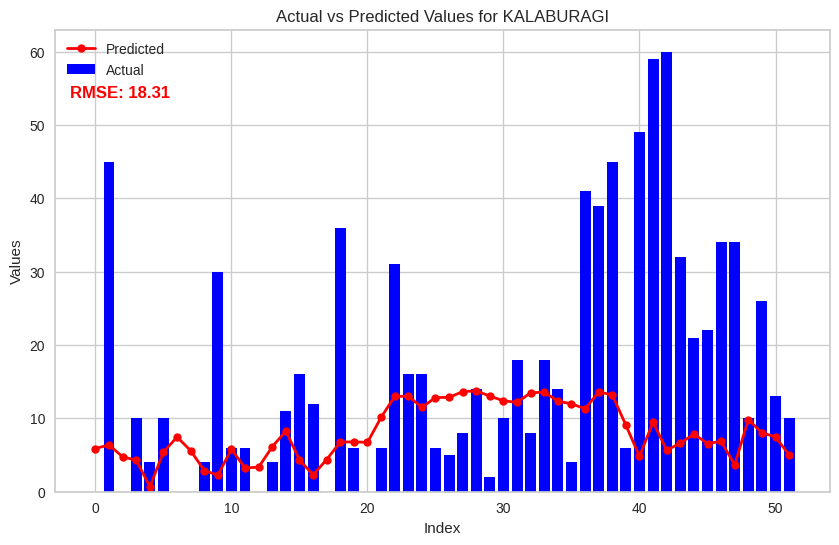

Analyzing District: KODAGU


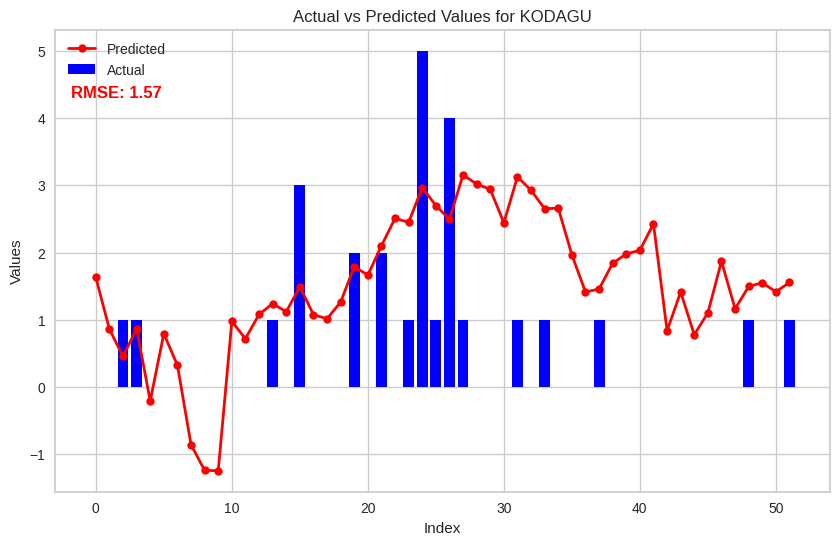

Analyzing District: KOLAR


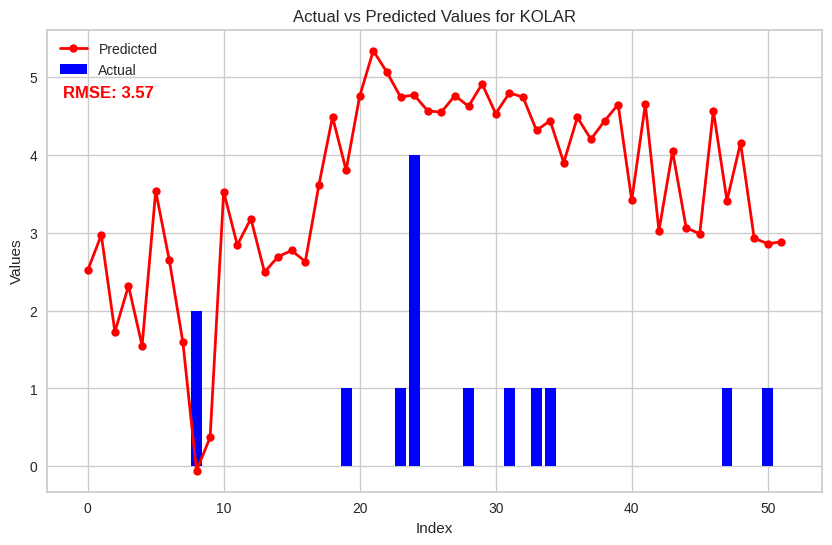

Analyzing District: KOPPAL


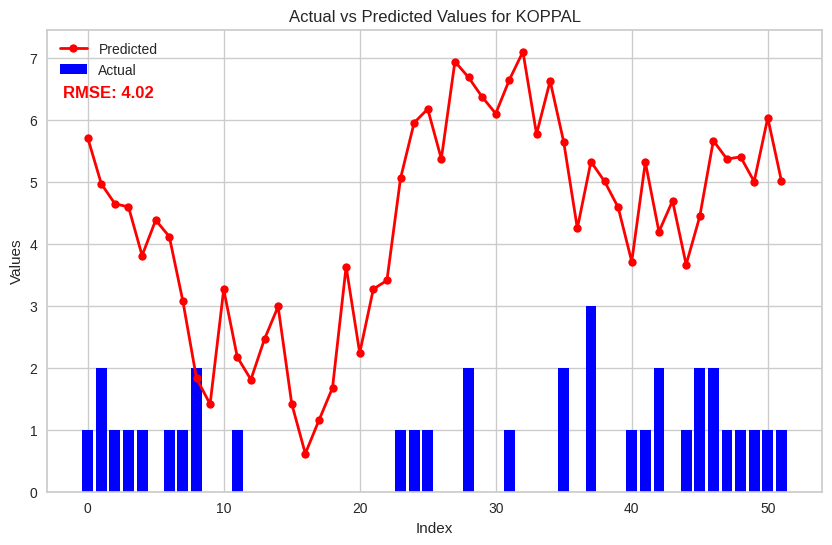

Analyzing District: MANDYA


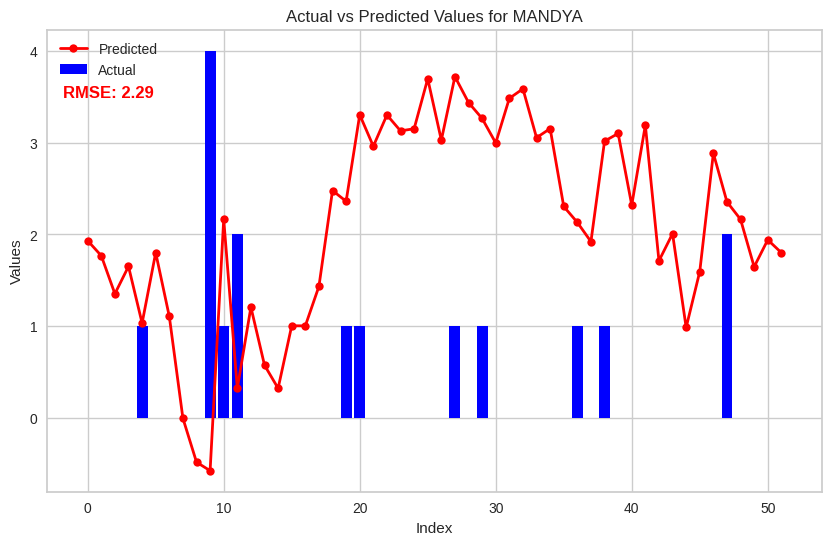

Analyzing District: MYSURU


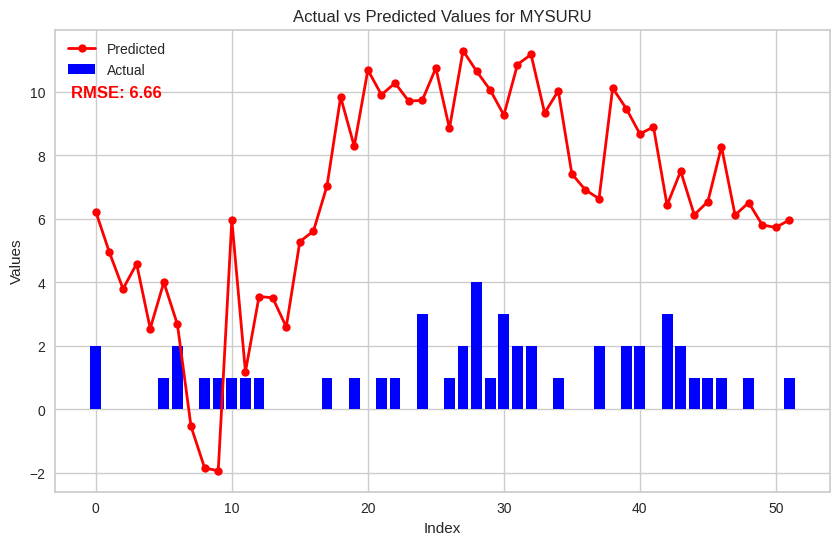

Analyzing District: RAICHUR


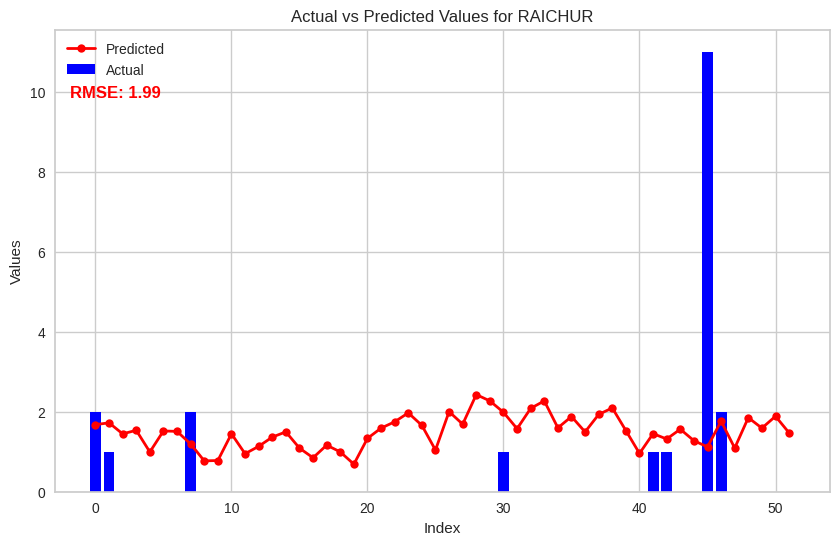

Analyzing District: RAMANAGARA


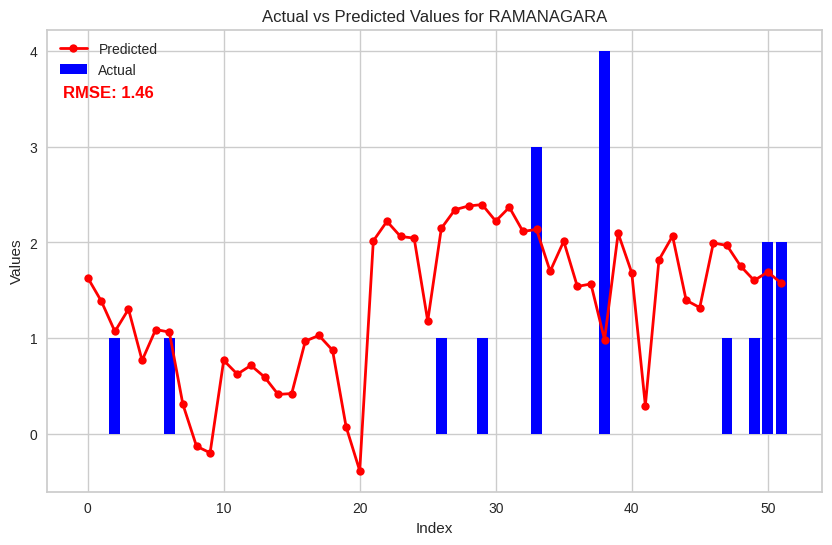

Analyzing District: SHIVAMOGGA


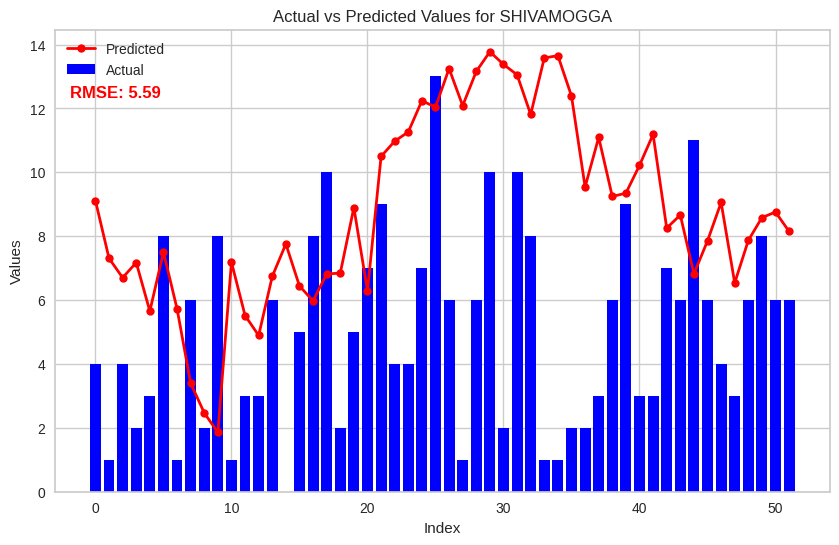

Analyzing District: TUMAKURU


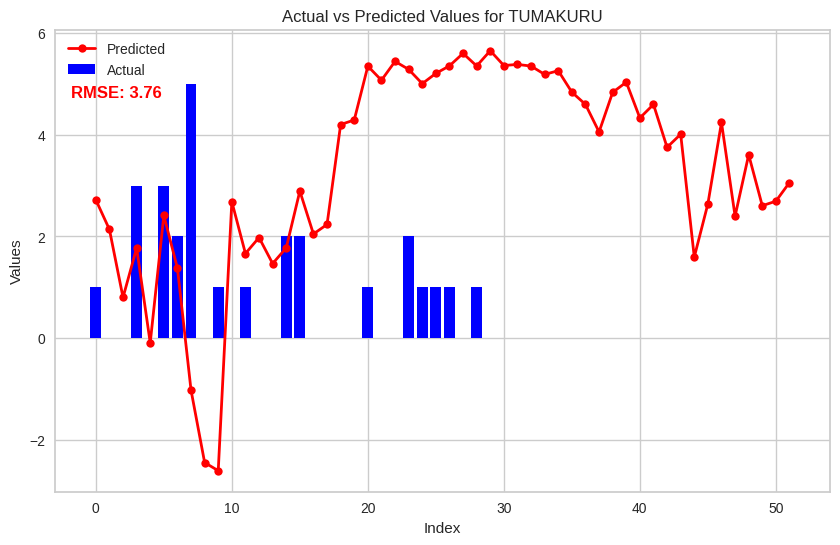

Analyzing District: UDUPI


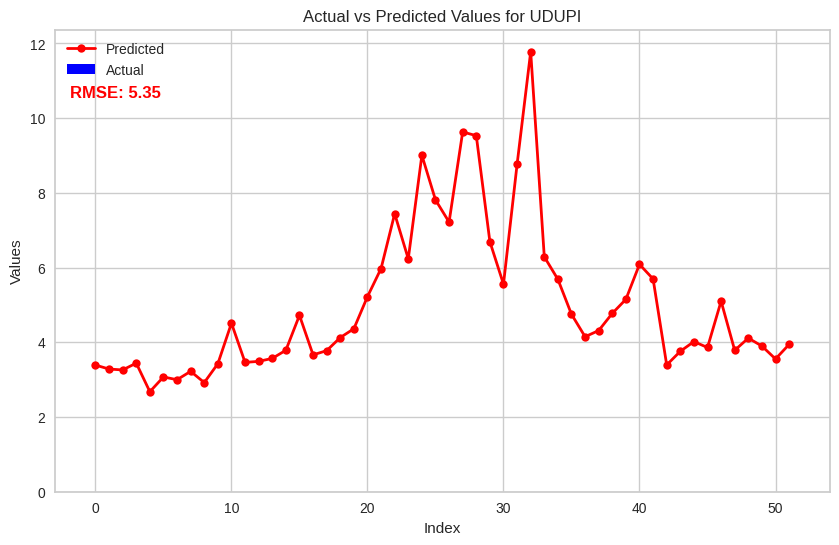

Analyzing District: UTTARA KANNADA


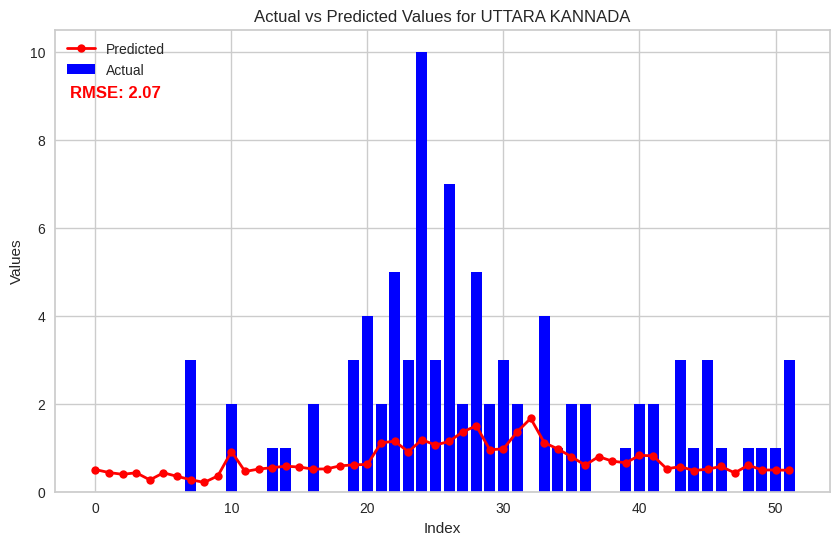

Analyzing District: VIJAYANAGAR


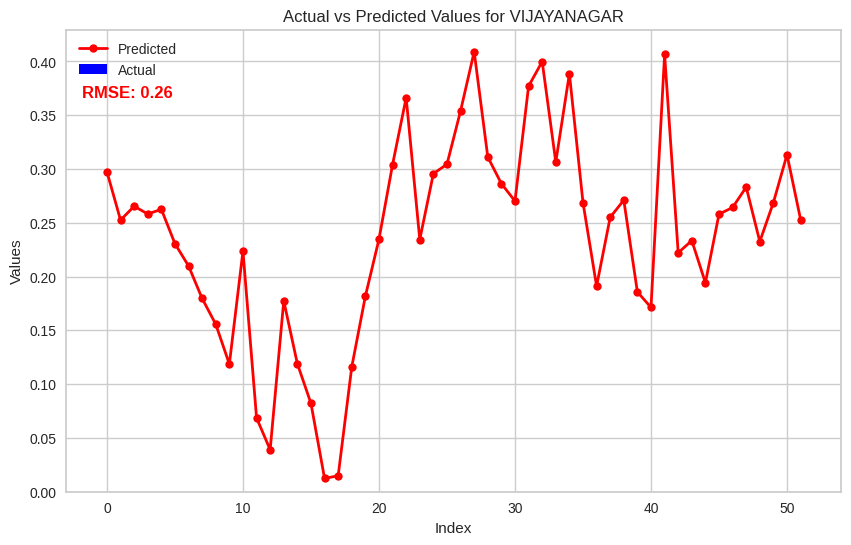

Analyzing District: VIJAYAPURA


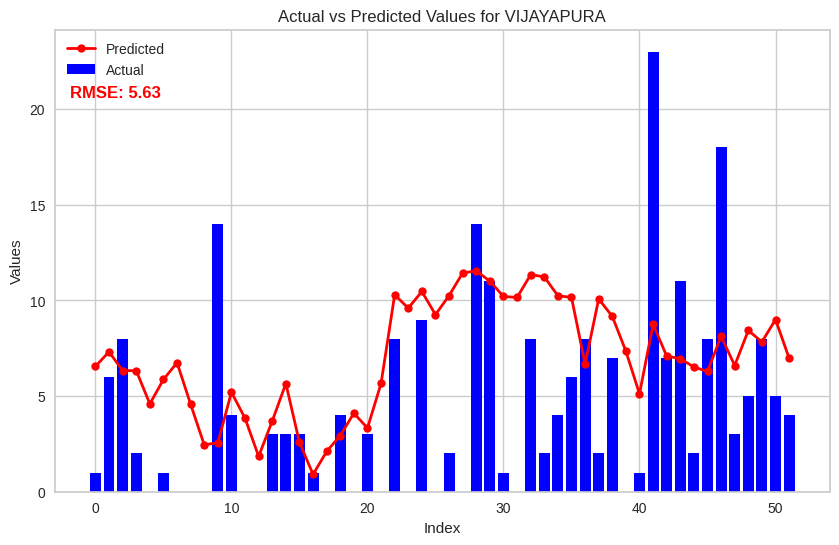

Analyzing District: YADGIR


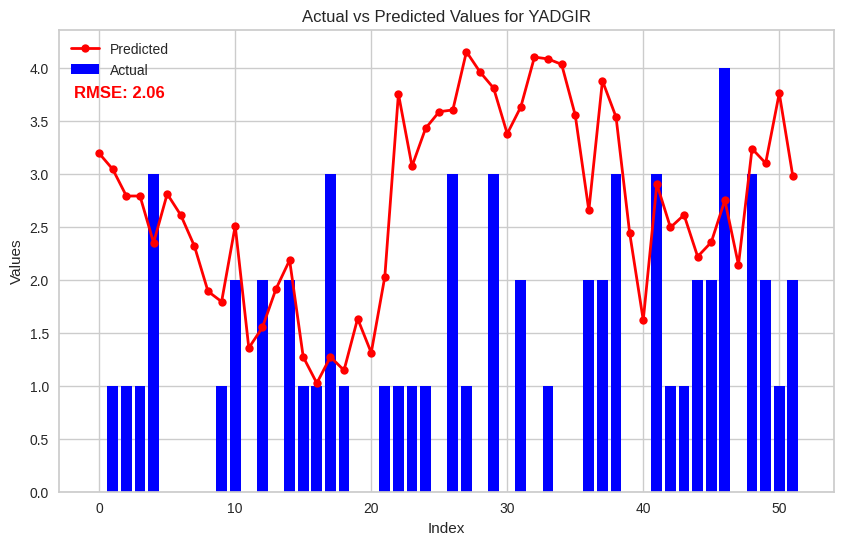

In [26]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2018)
df_2018 = district_analysis.analyze_districts()

Analyzing District: BAGALKOTE


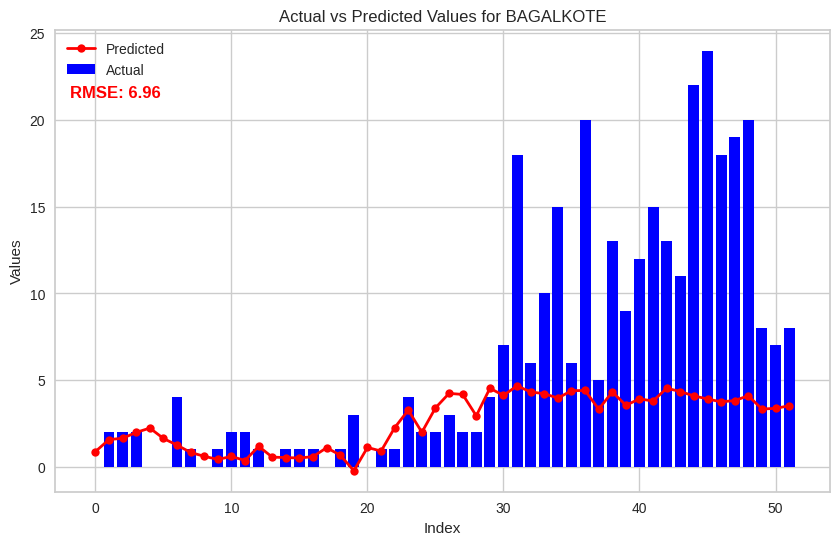

Analyzing District: BALLARI


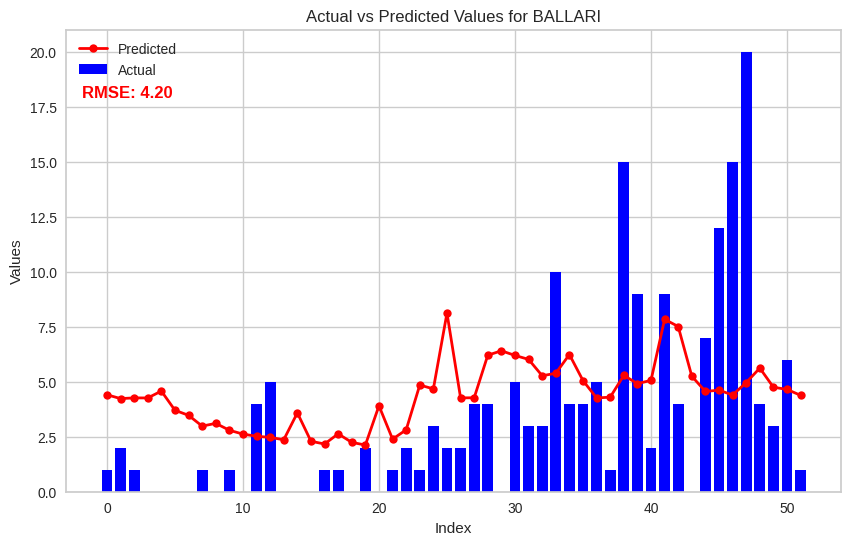

Analyzing District: BELAGAVI


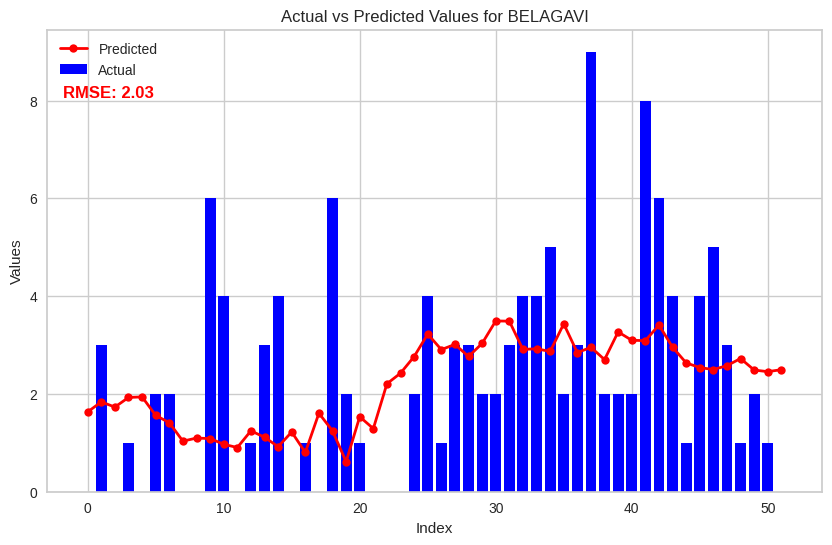

Analyzing District: BENGALURU RURAL


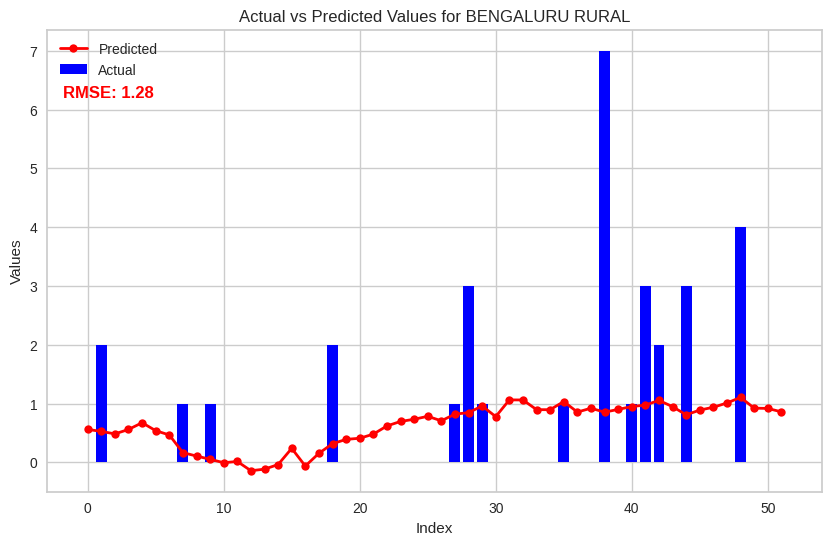

Analyzing District: BENGALURU URBAN


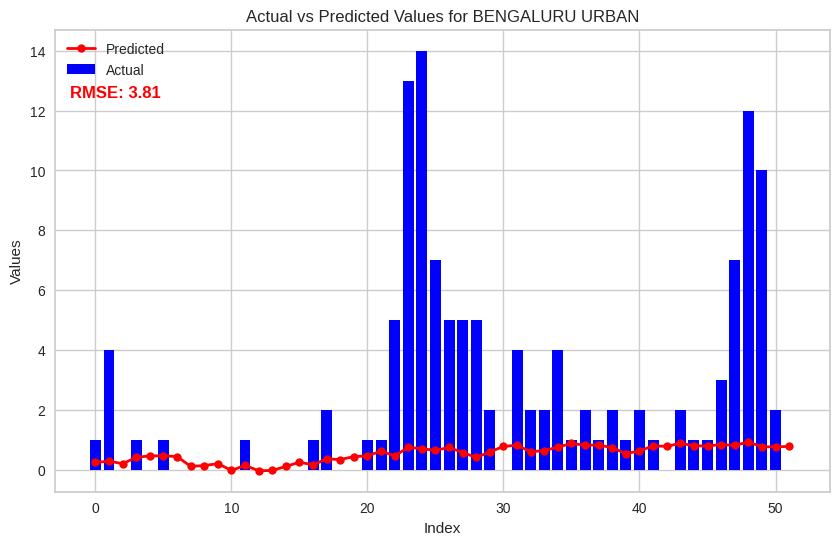

Analyzing District: BIDAR


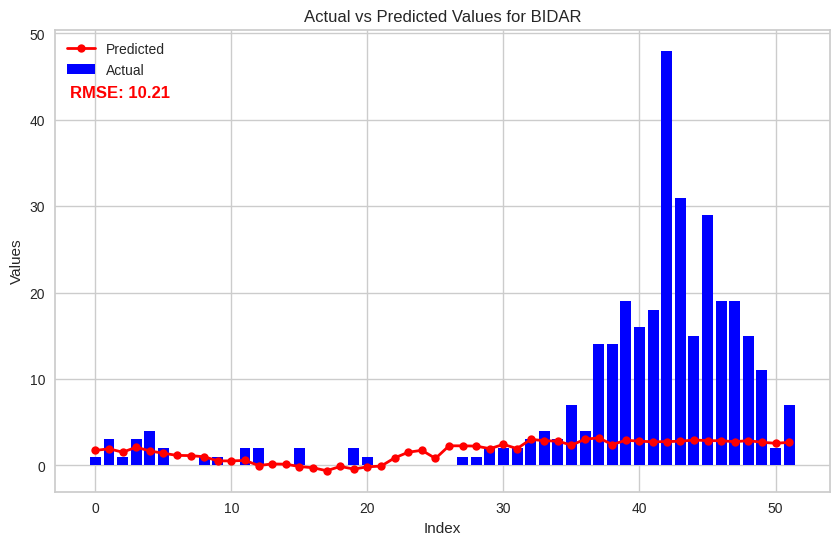

Analyzing District: CHAMARAJANAGARA


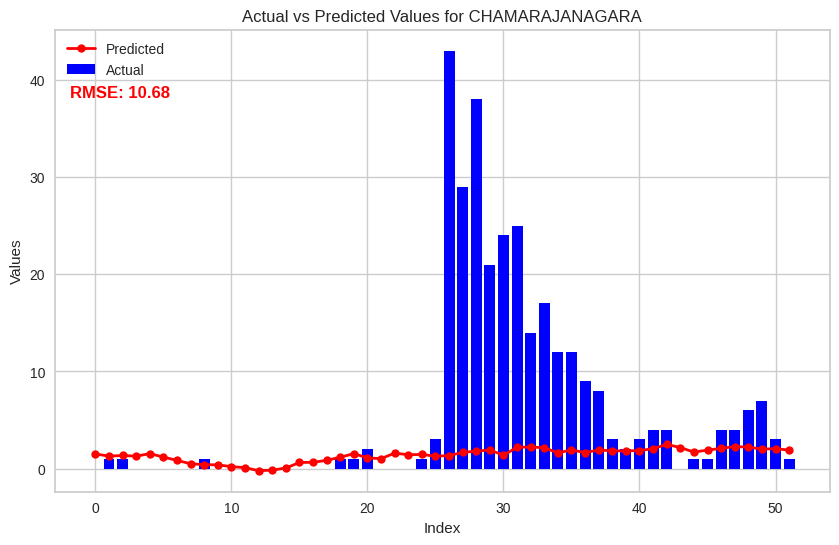

Analyzing District: CHIKKABALLAPURA


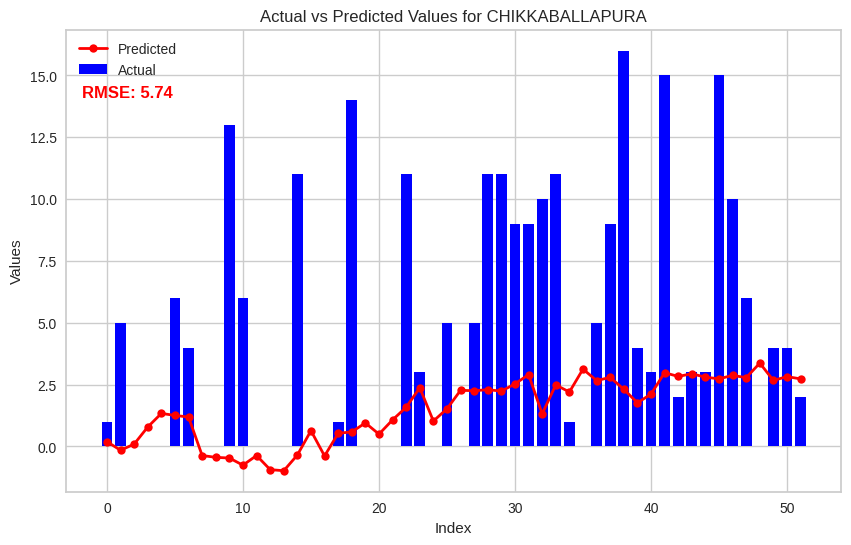

Analyzing District: CHIKKAMAGALURU


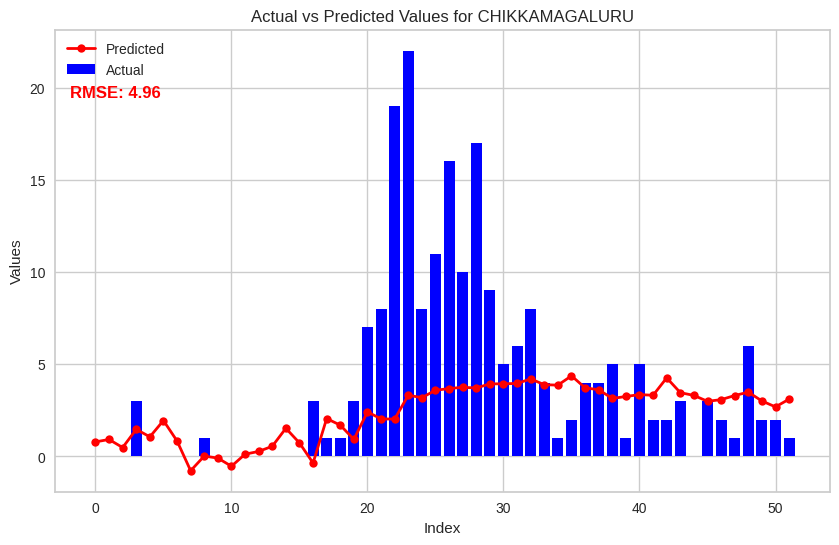

Analyzing District: CHITRADURGA


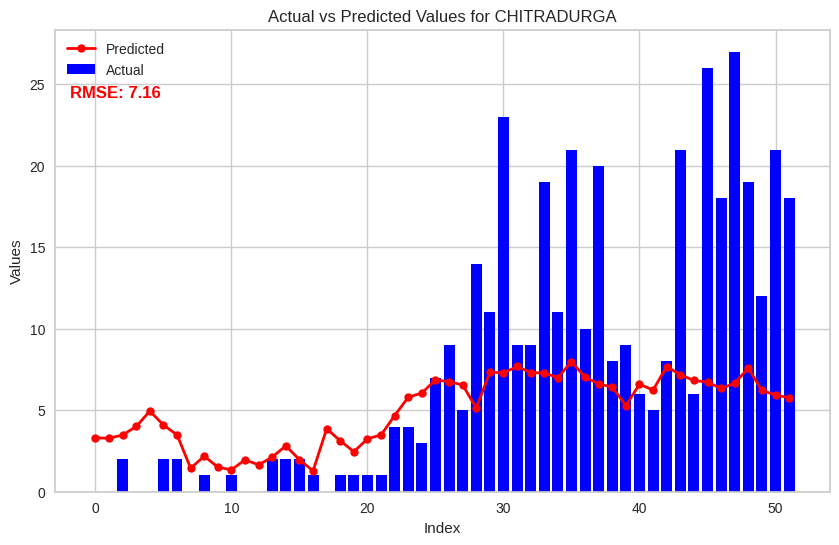

Analyzing District: DAKSHINA KANNADA


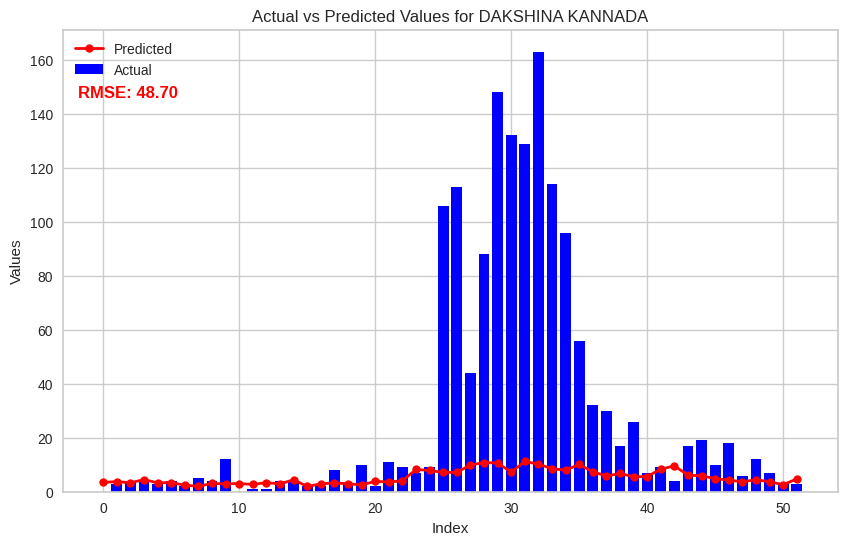

Analyzing District: DAVANGERE


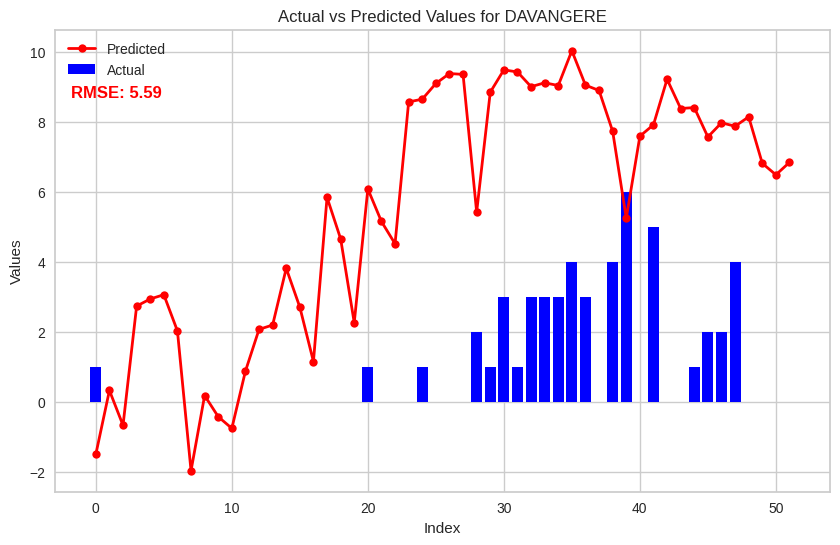

Analyzing District: DHARWAD


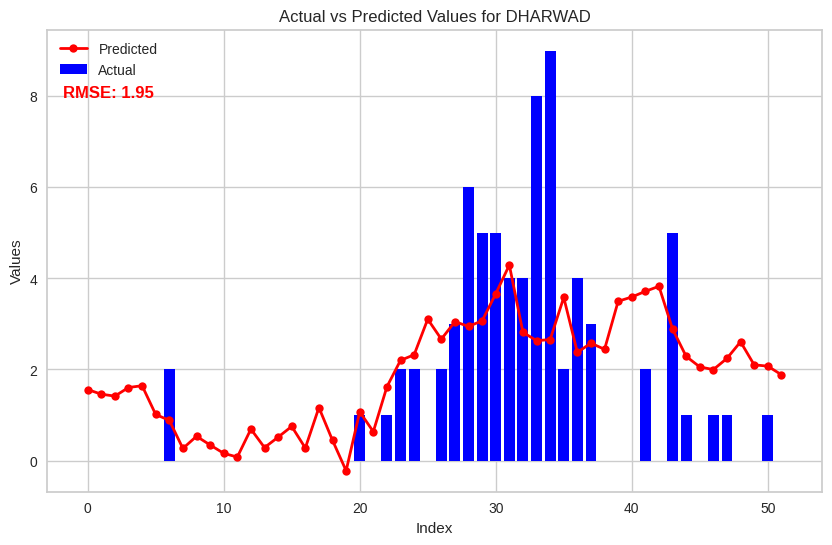

Analyzing District: GADAG


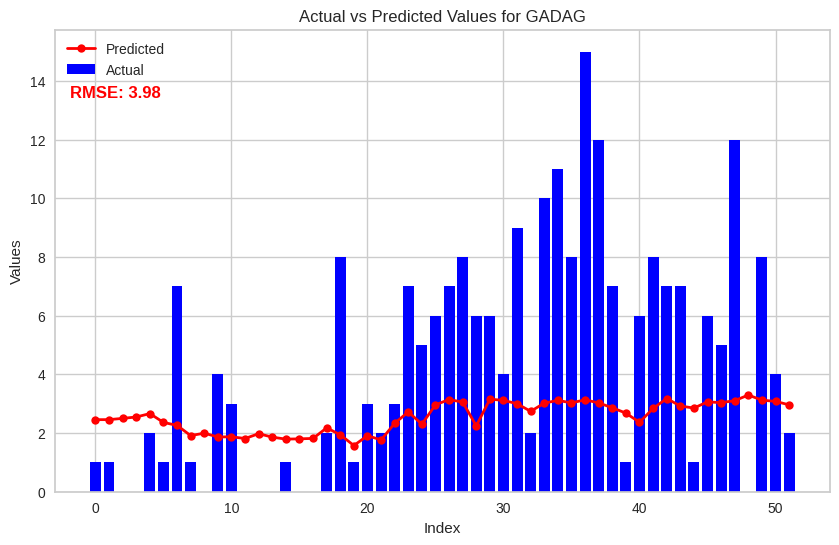

Analyzing District: HASSAN


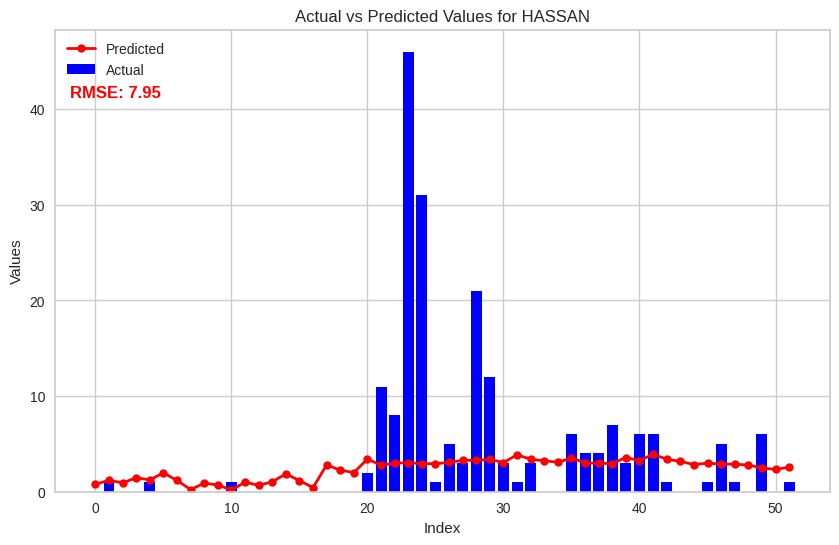

Analyzing District: HAVERI


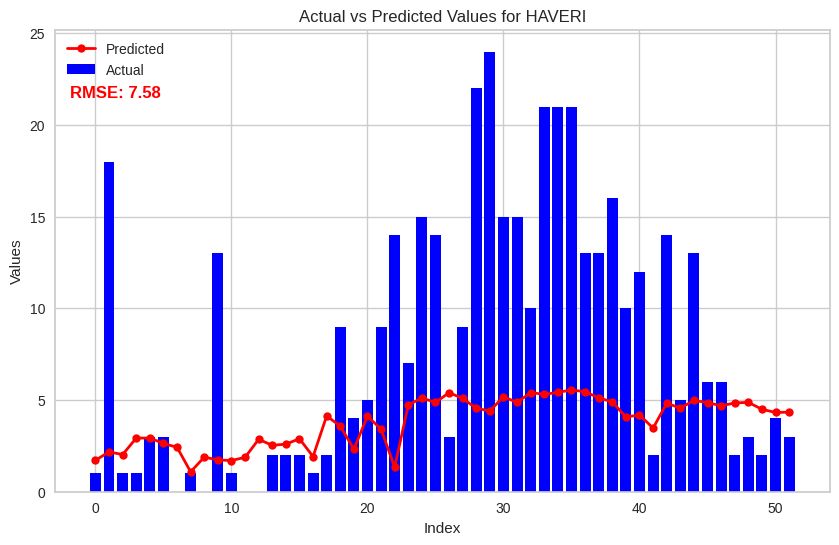

Analyzing District: KALABURAGI


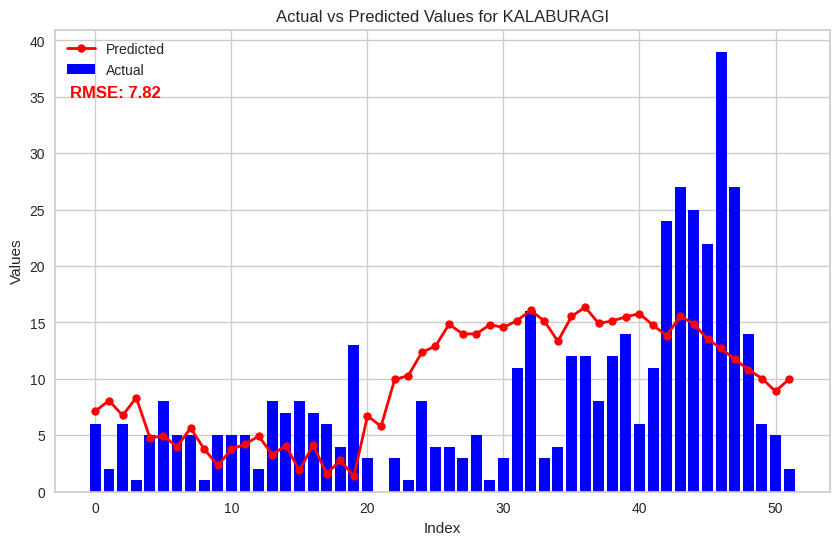

Analyzing District: KODAGU


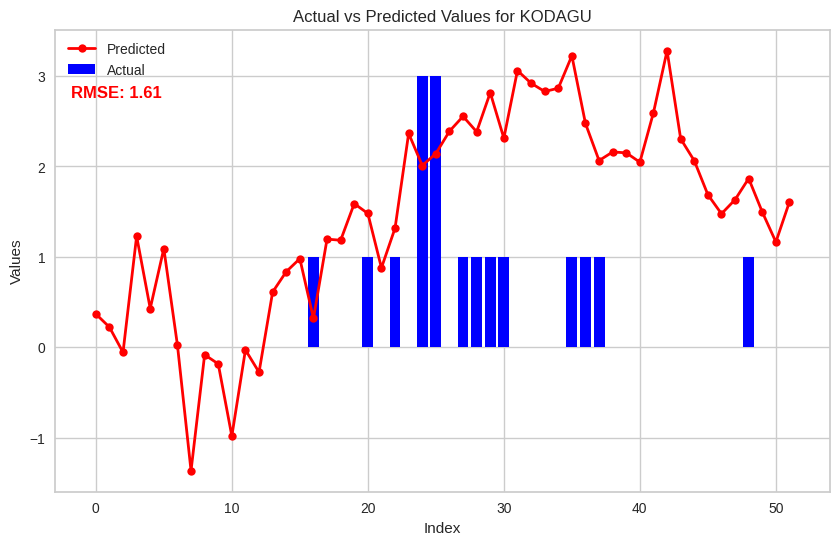

Analyzing District: KOLAR


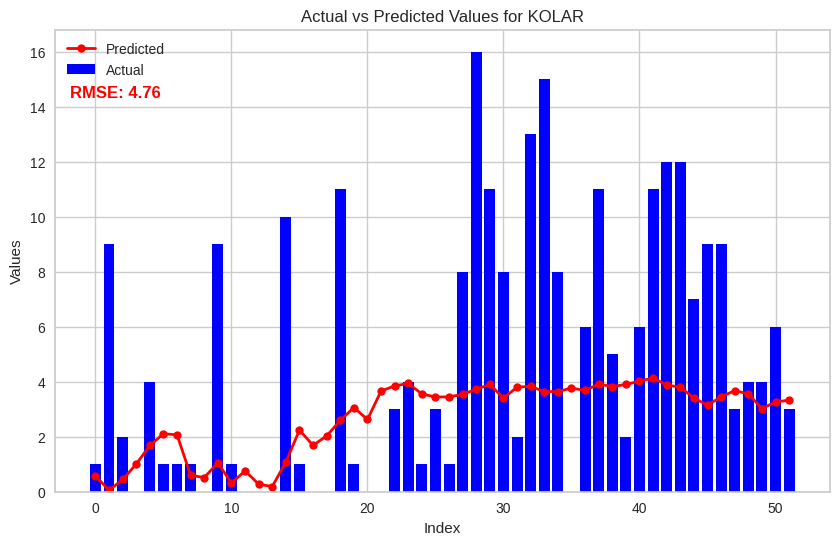

Analyzing District: KOPPAL


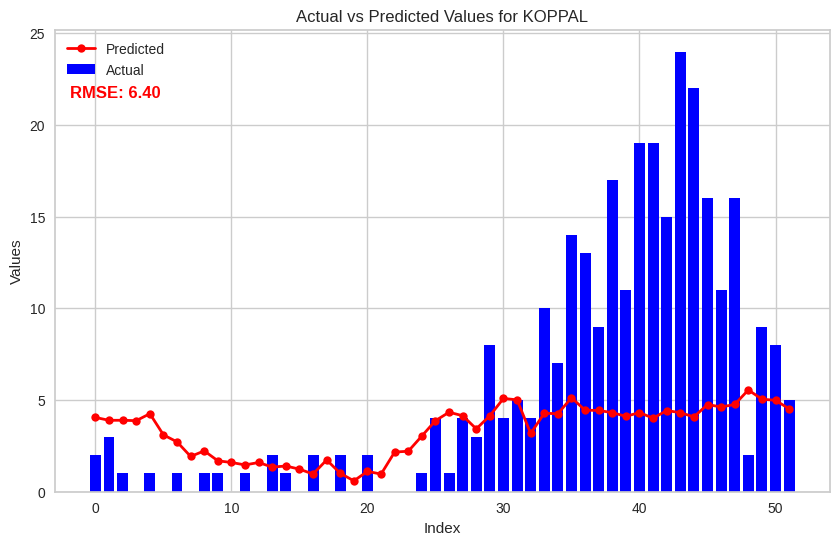

Analyzing District: MANDYA


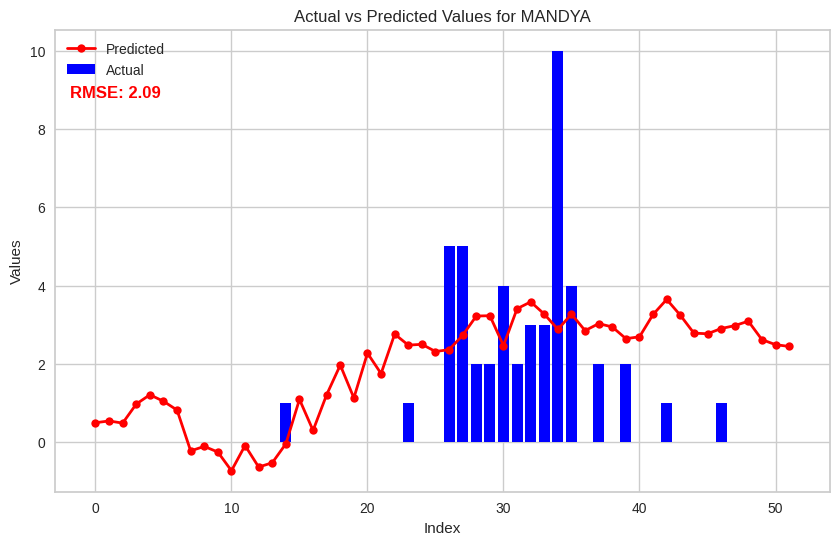

Analyzing District: MYSURU


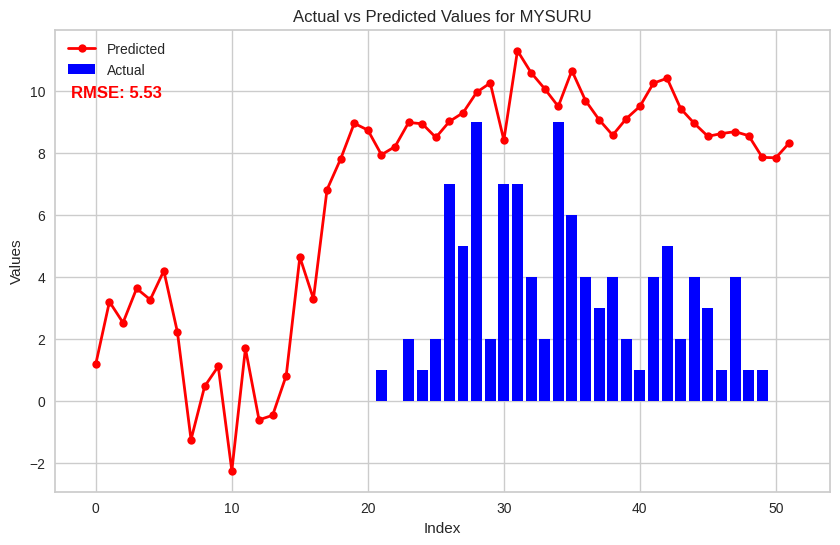

Analyzing District: RAICHUR


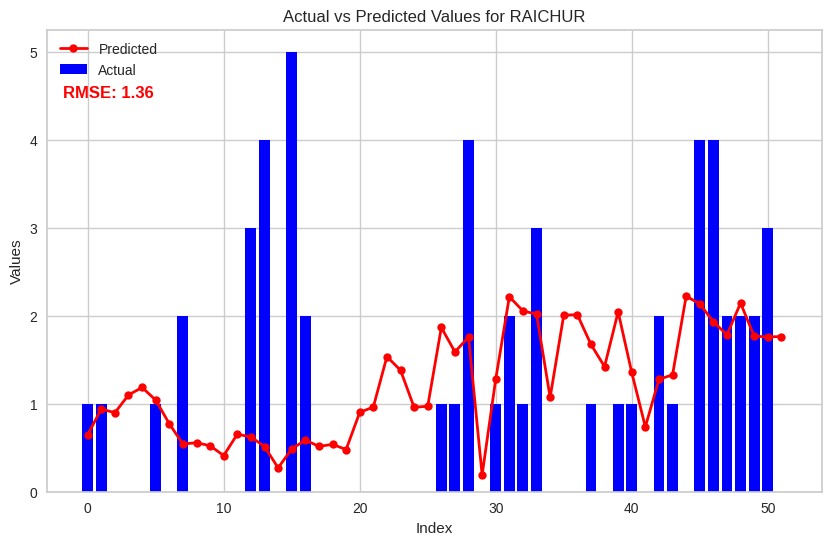

Analyzing District: RAMANAGARA


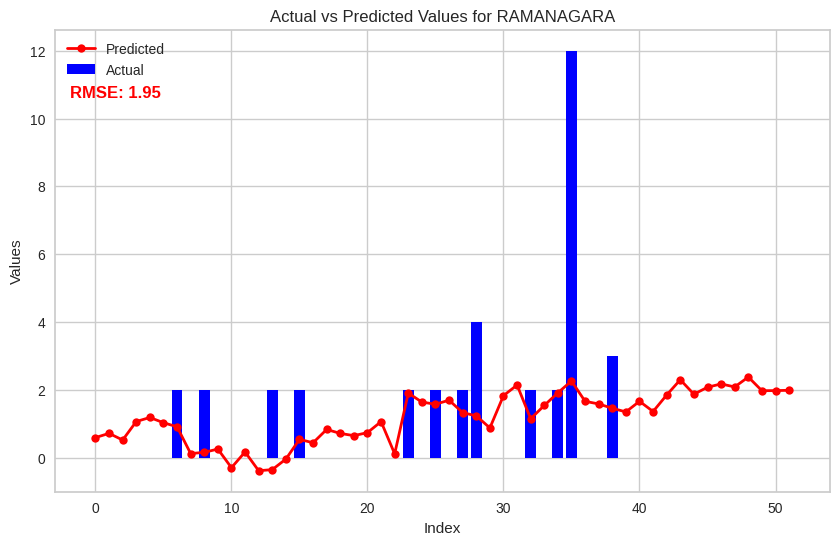

Analyzing District: SHIVAMOGGA


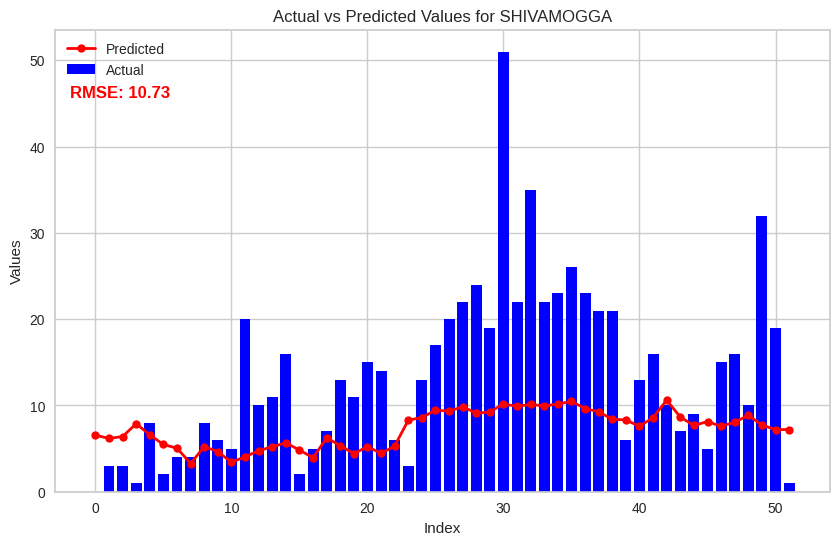

Analyzing District: TUMAKURU


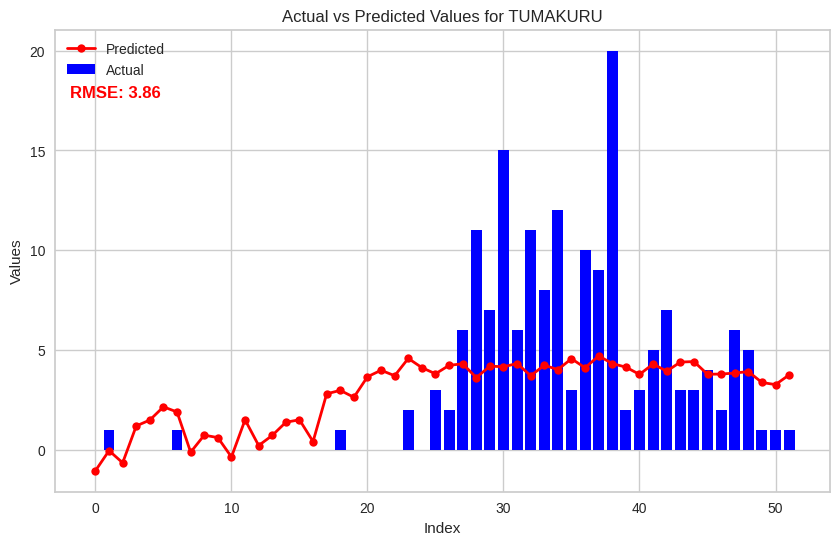

Analyzing District: UDUPI


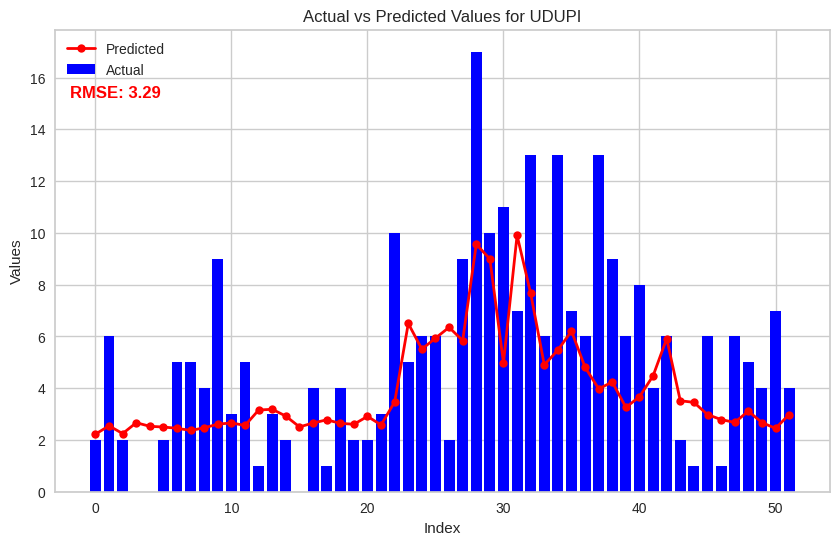

Analyzing District: UTTARA KANNADA


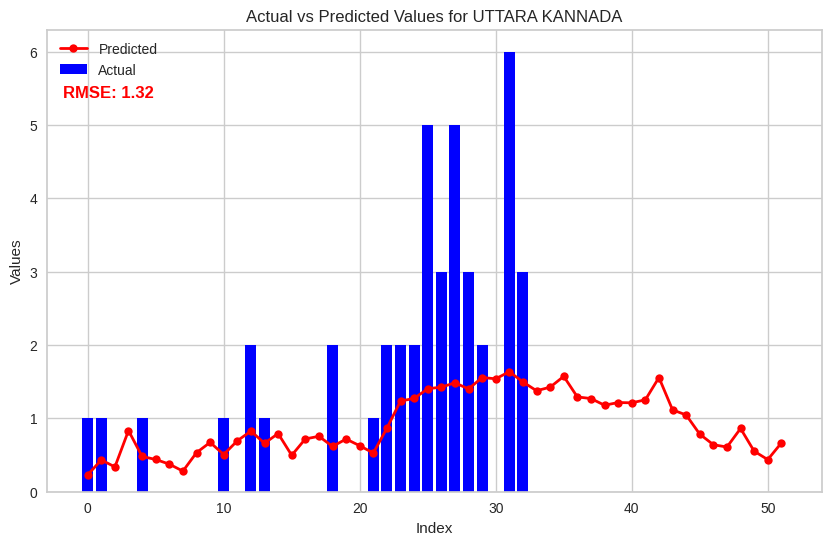

Analyzing District: VIJAYANAGAR


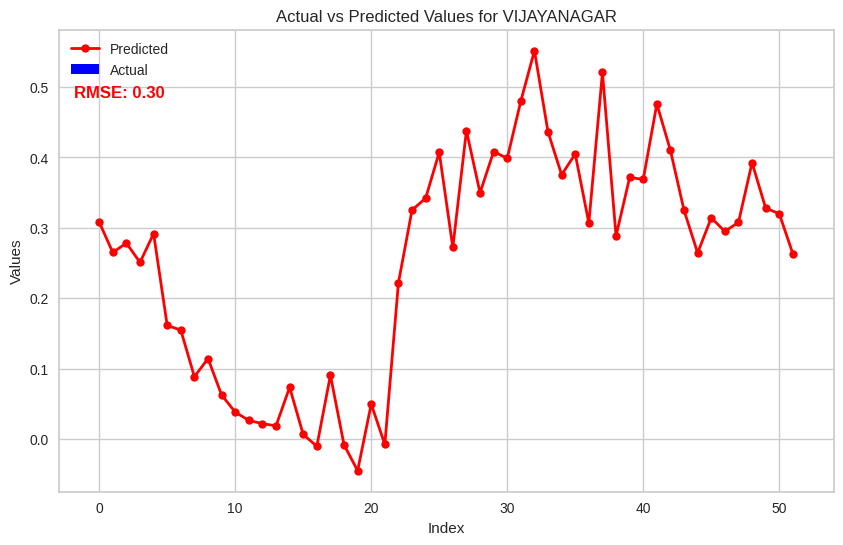

Analyzing District: VIJAYAPURA


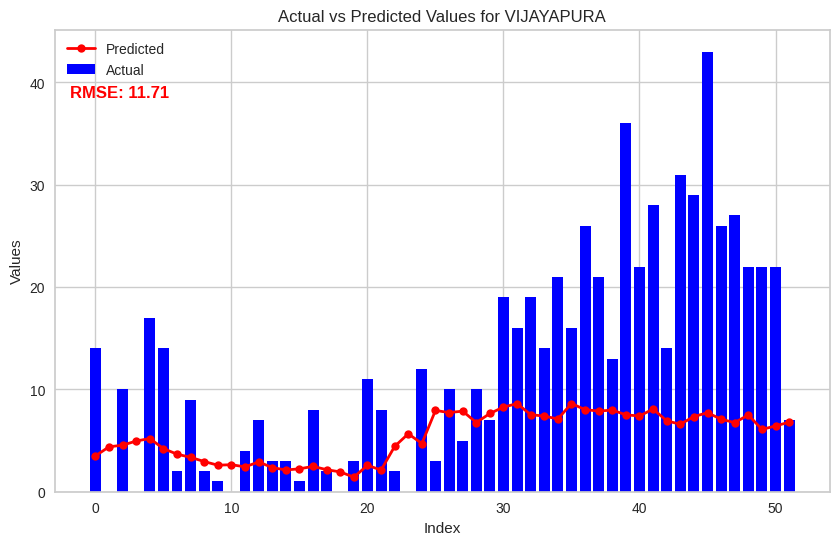

Analyzing District: YADGIR


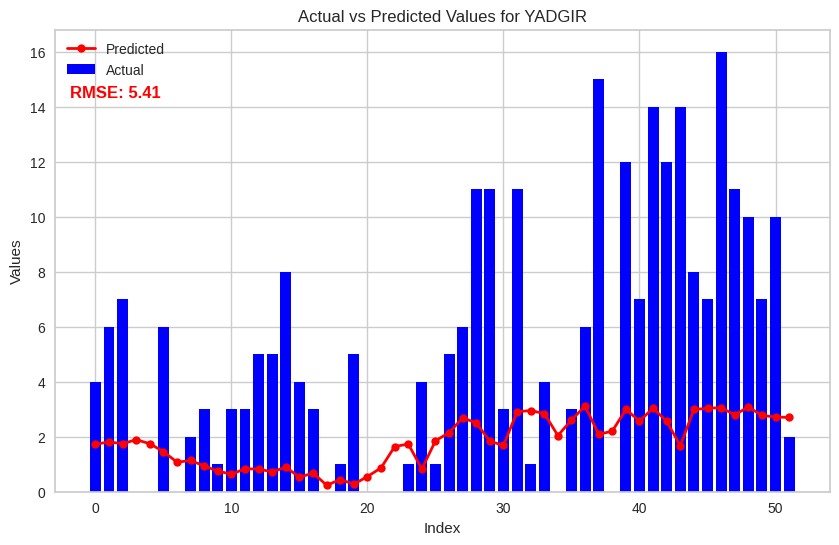

In [27]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2019)
df_2019 = district_analysis.analyze_districts()

Analyzing District: BAGALKOTE


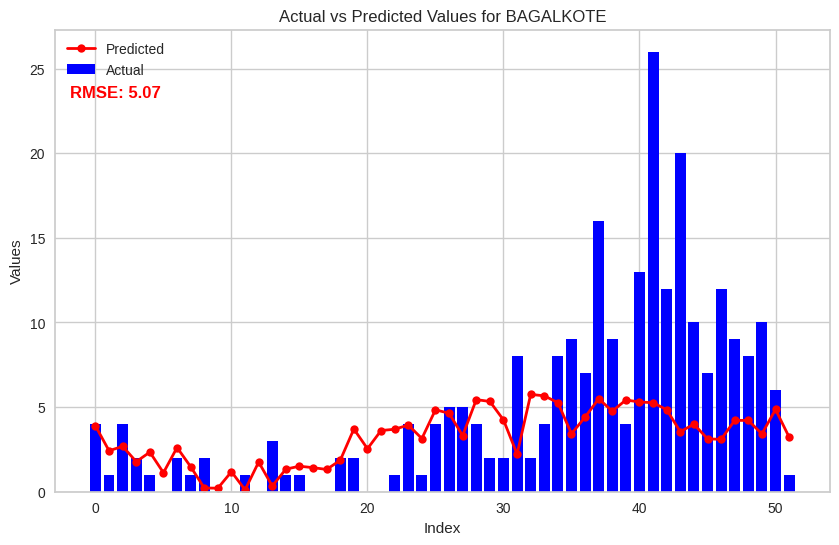

Analyzing District: BALLARI


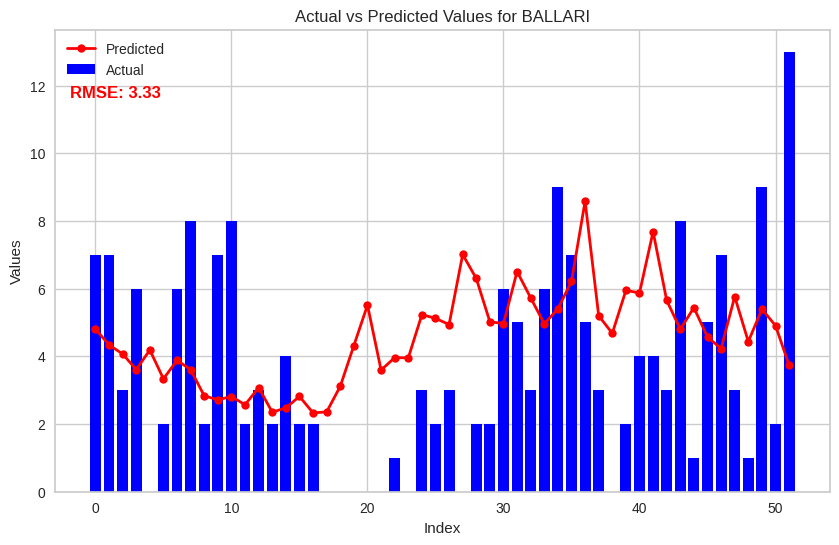

Analyzing District: BELAGAVI


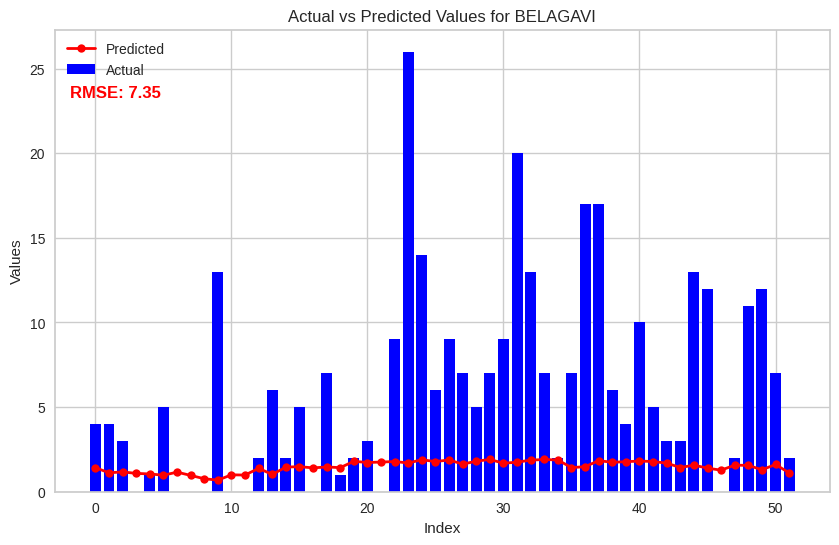

Analyzing District: BENGALURU RURAL


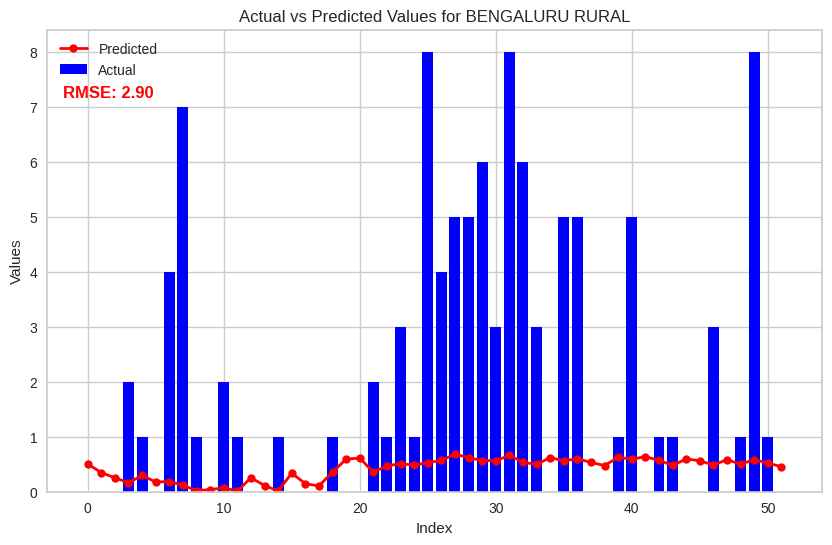

Analyzing District: BENGALURU URBAN


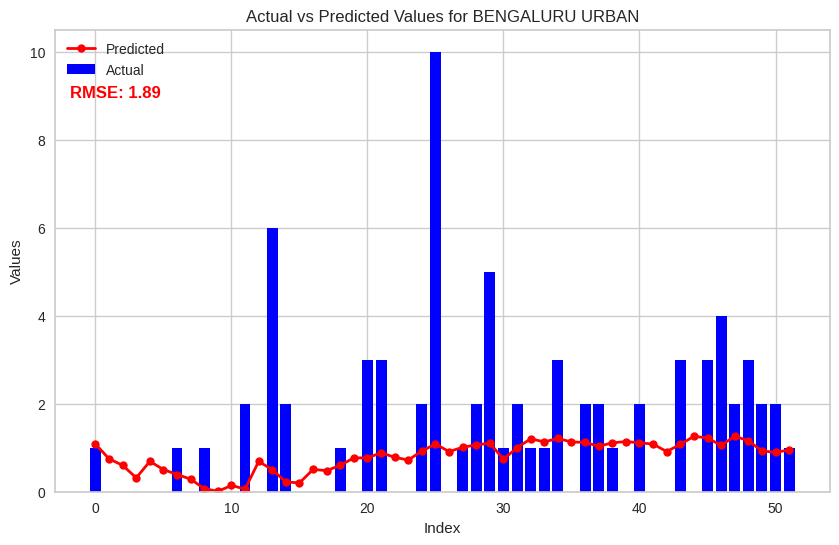

Analyzing District: BIDAR


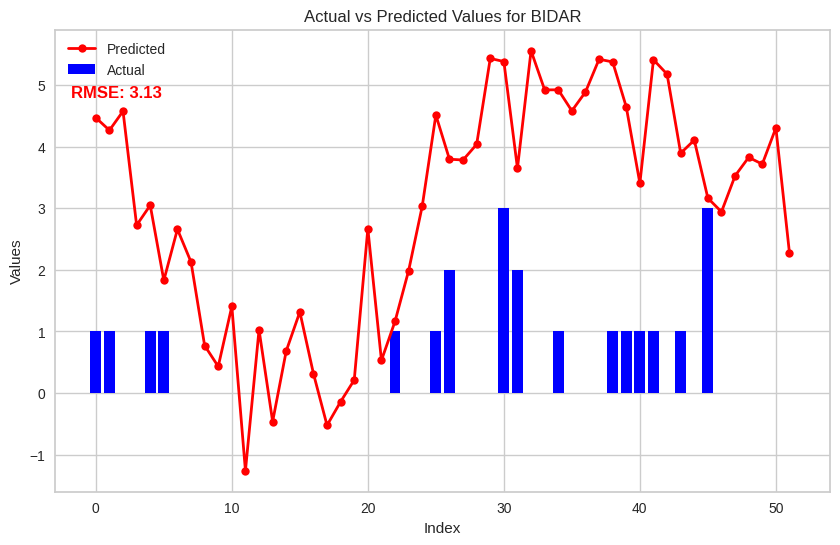

Analyzing District: CHAMARAJANAGARA


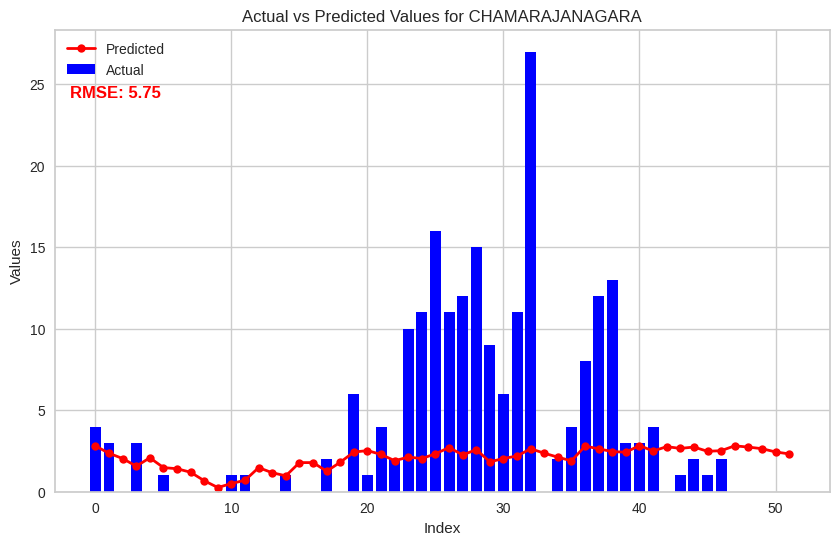

Analyzing District: CHIKKABALLAPURA


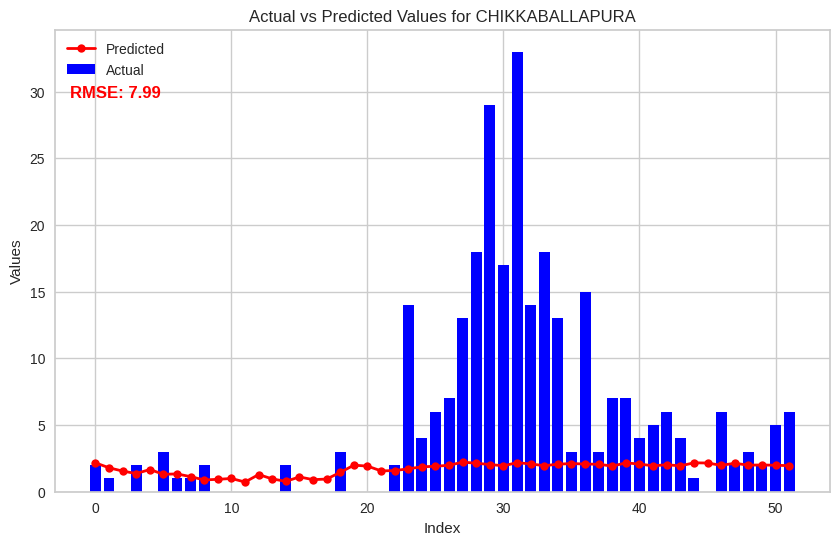

Analyzing District: CHIKKAMAGALURU


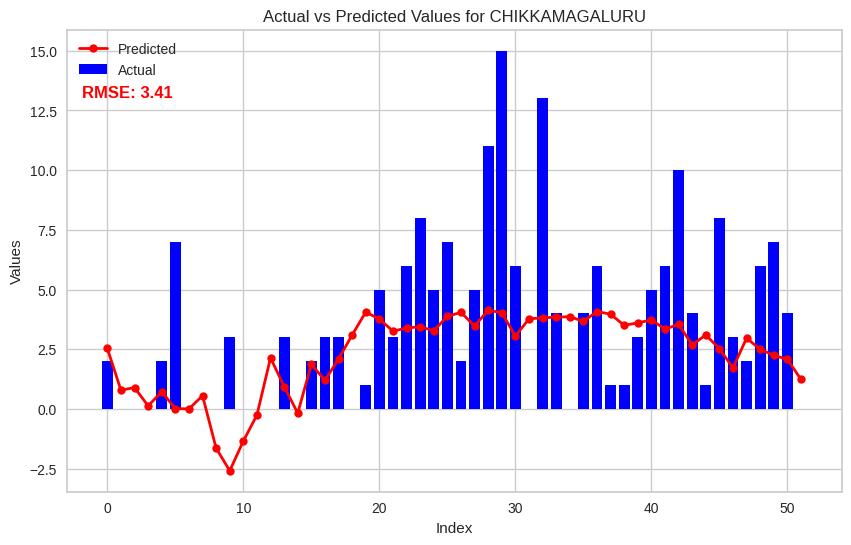

Analyzing District: CHITRADURGA


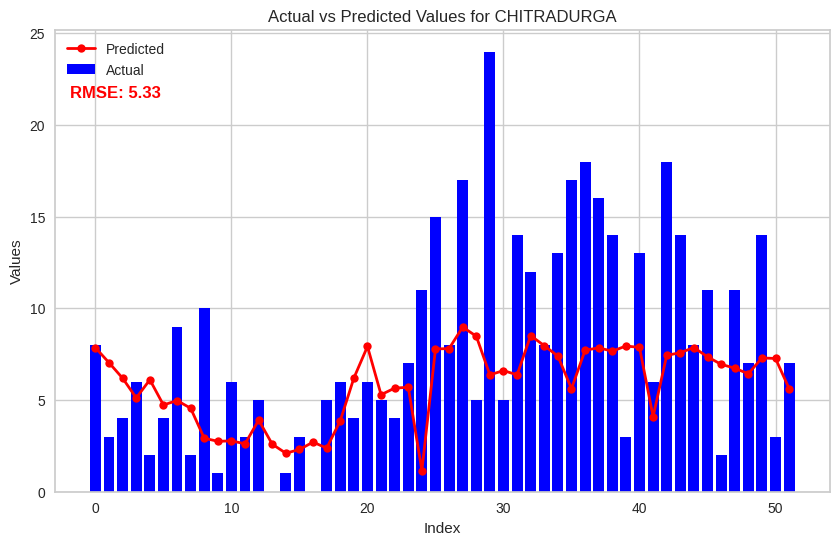

Analyzing District: DAKSHINA KANNADA


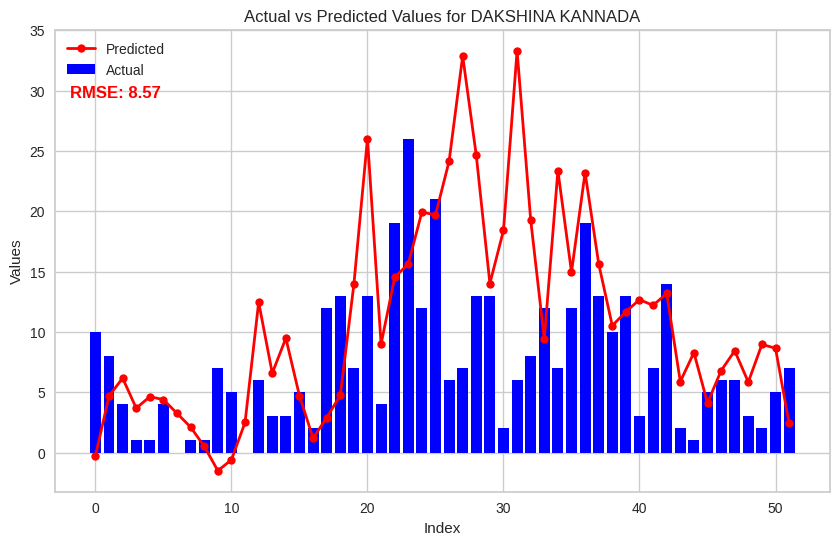

Analyzing District: DAVANGERE


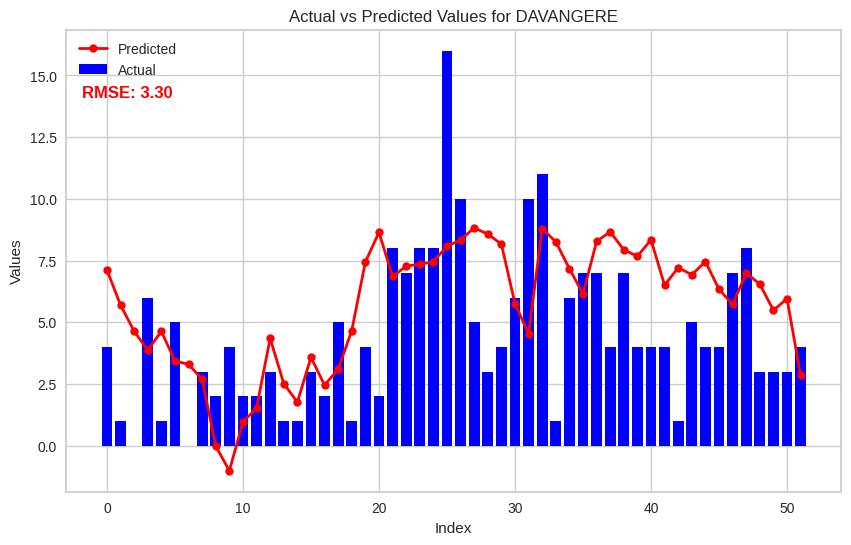

Analyzing District: DHARWAD


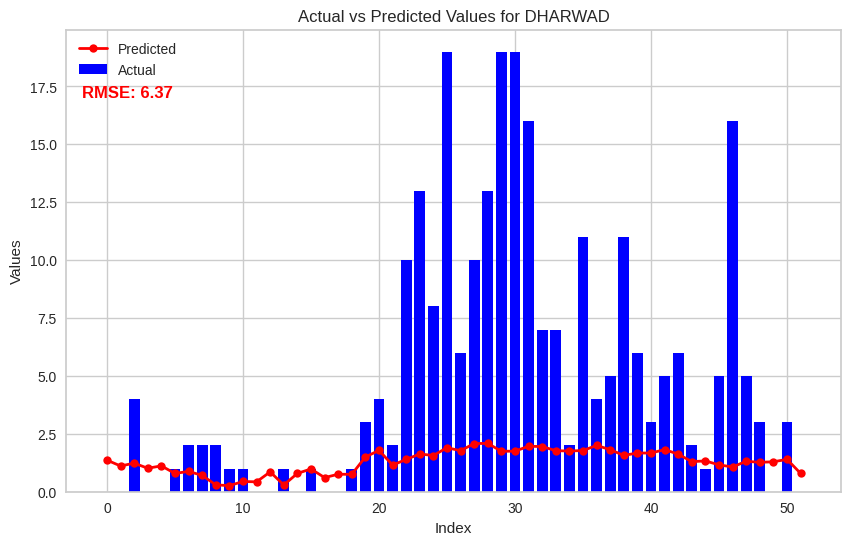

Analyzing District: GADAG


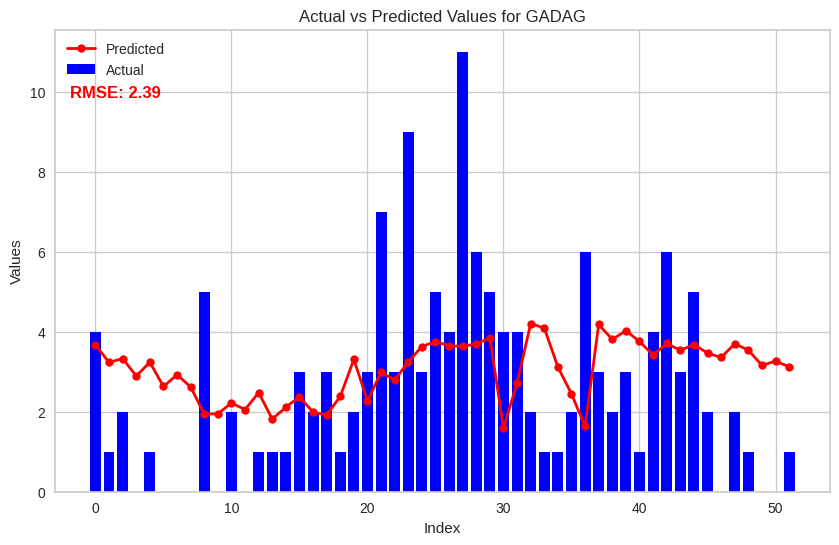

Analyzing District: HASSAN


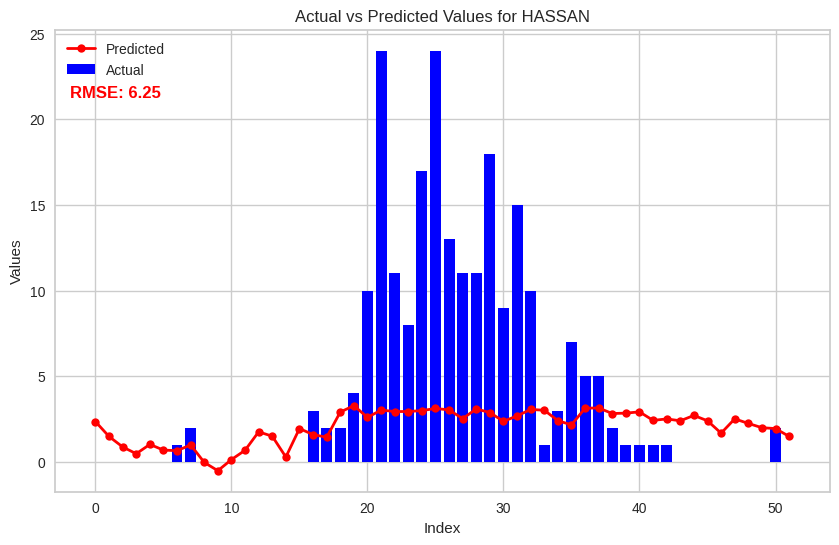

Analyzing District: HAVERI


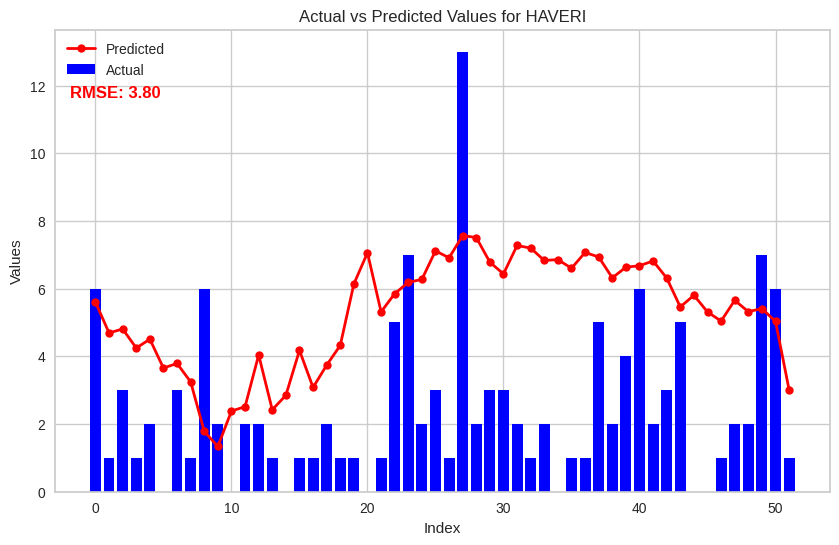

Analyzing District: KALABURAGI


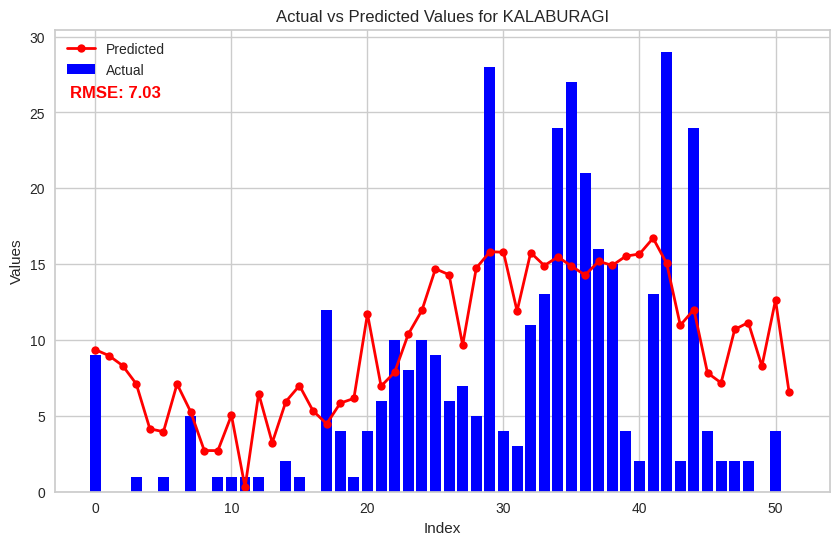

Analyzing District: KODAGU


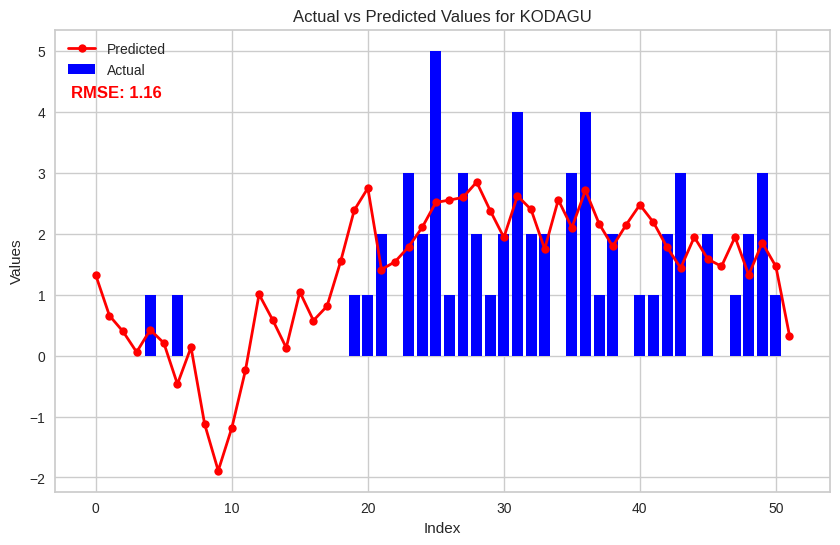

Analyzing District: KOLAR


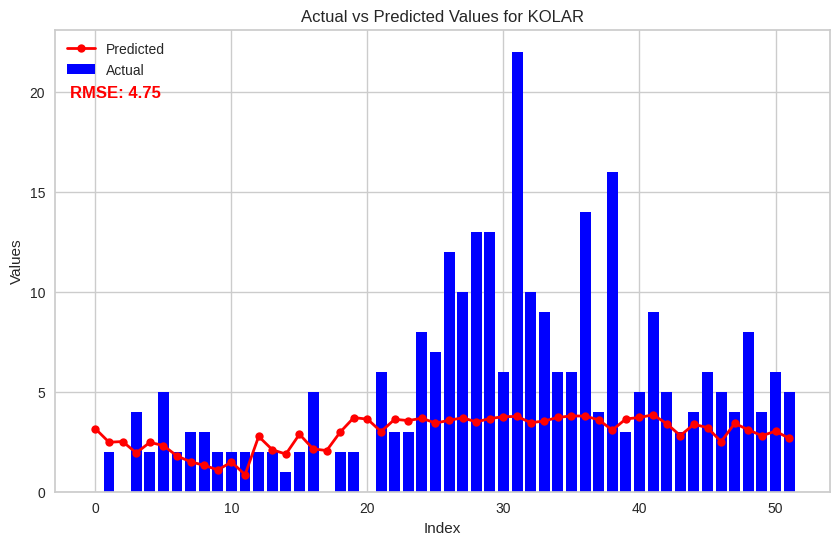

Analyzing District: KOPPAL


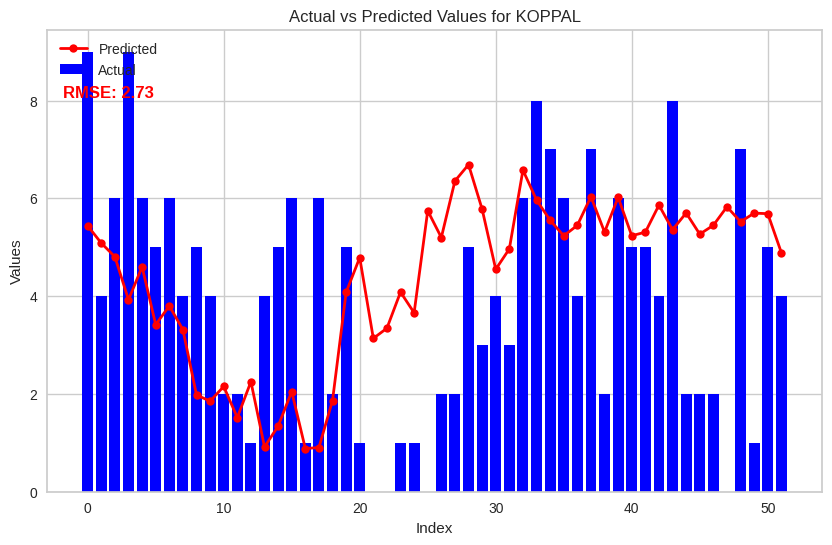

Analyzing District: MANDYA


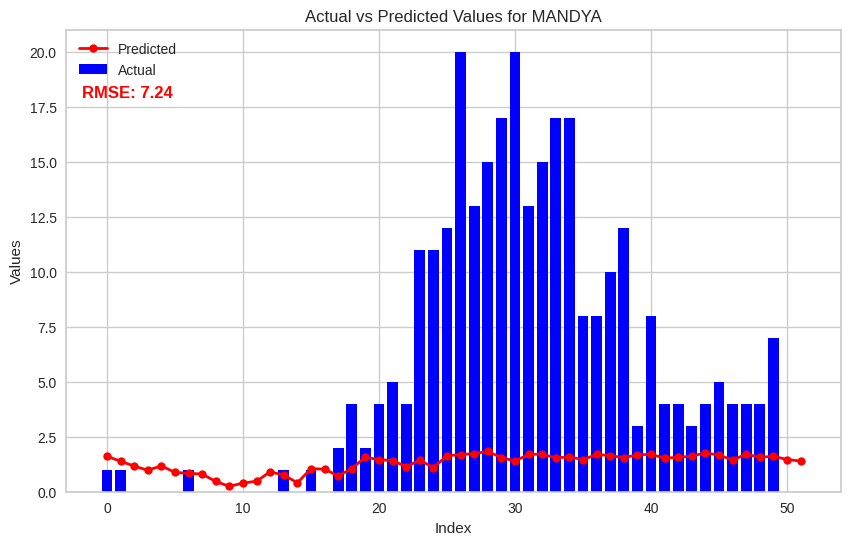

Analyzing District: MYSURU


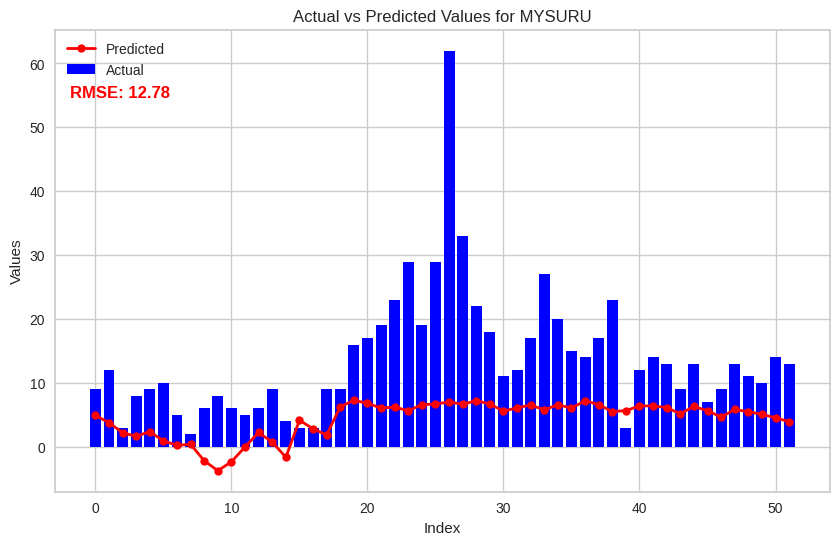

Analyzing District: RAICHUR


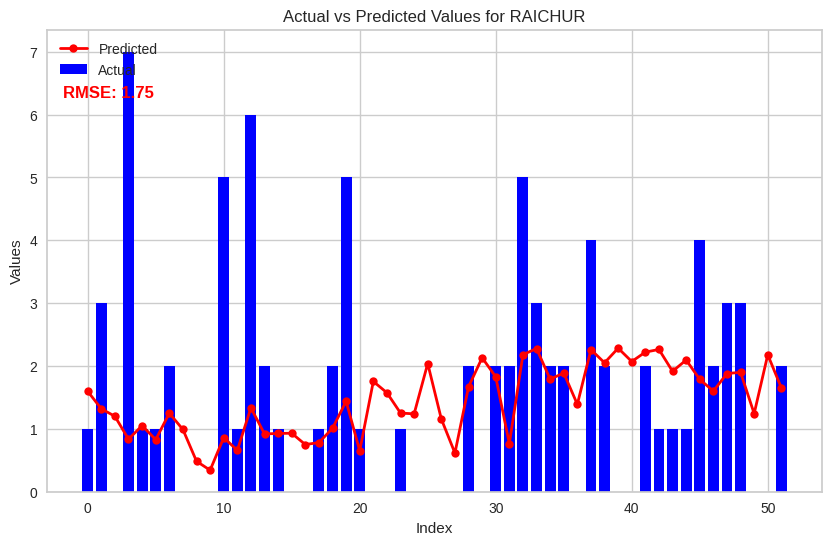

Analyzing District: RAMANAGARA


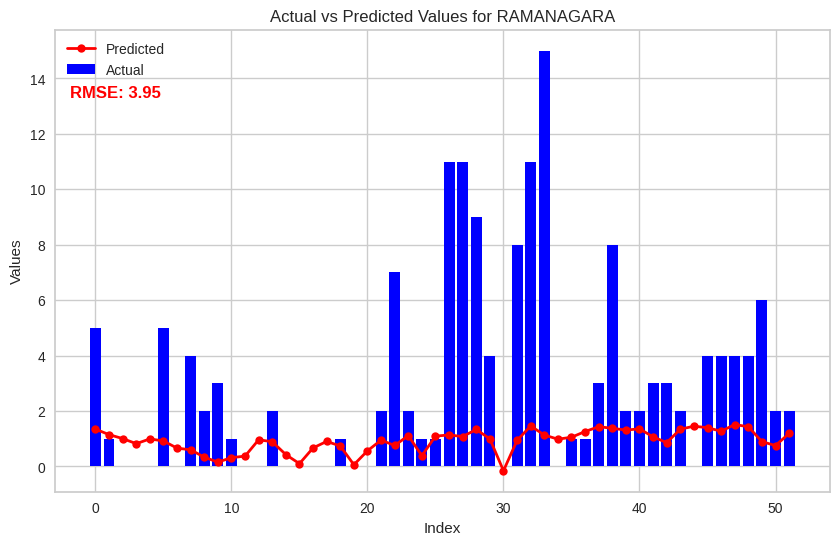

Analyzing District: SHIVAMOGGA


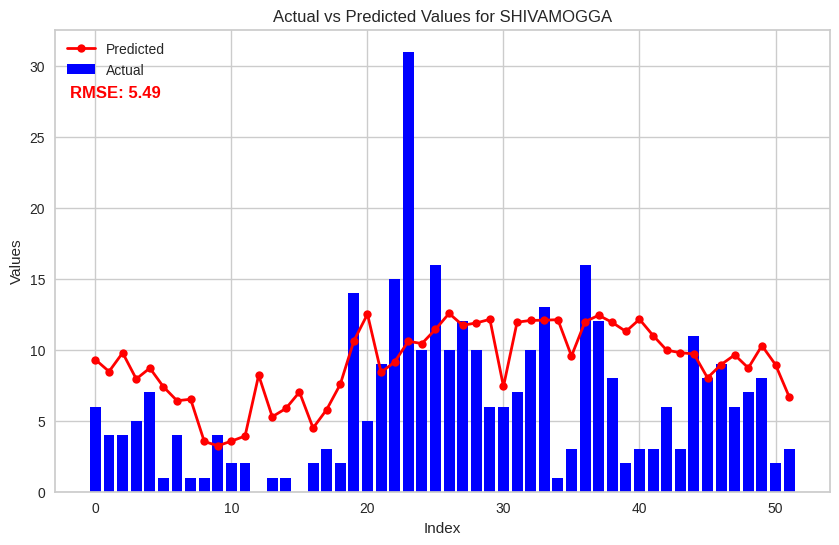

Analyzing District: TUMAKURU


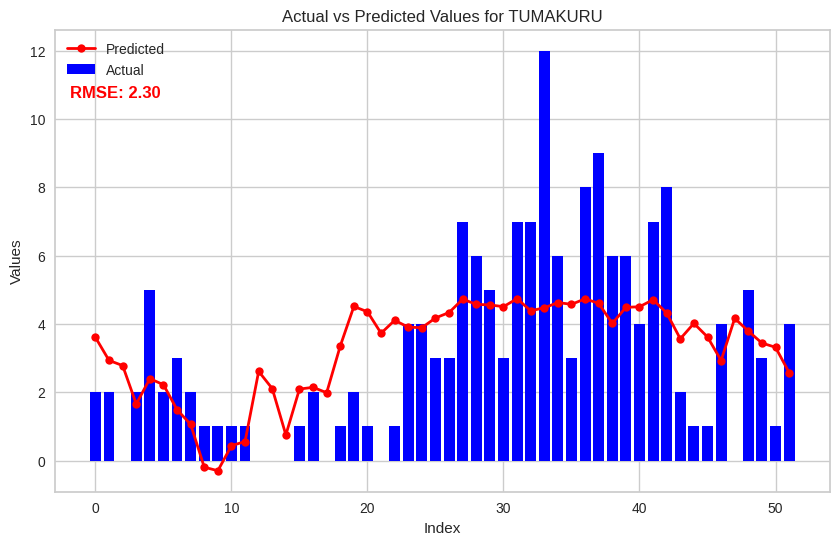

Analyzing District: UDUPI


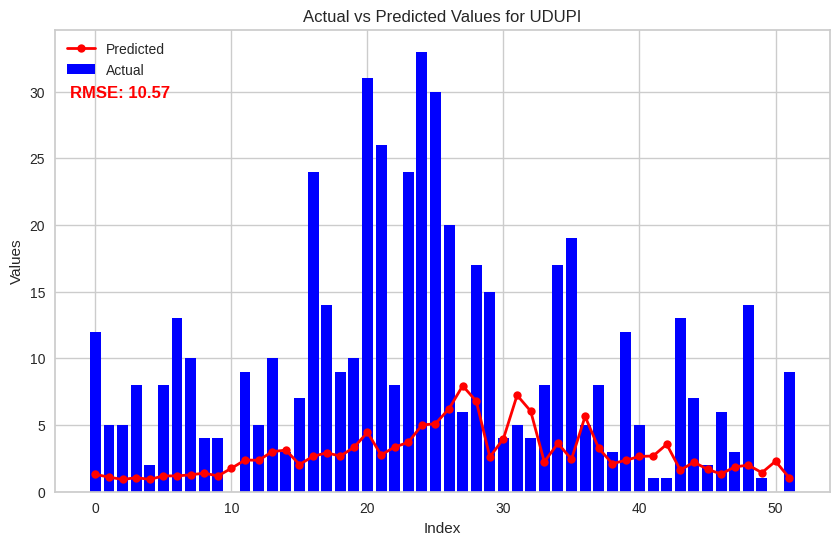

Analyzing District: UTTARA KANNADA


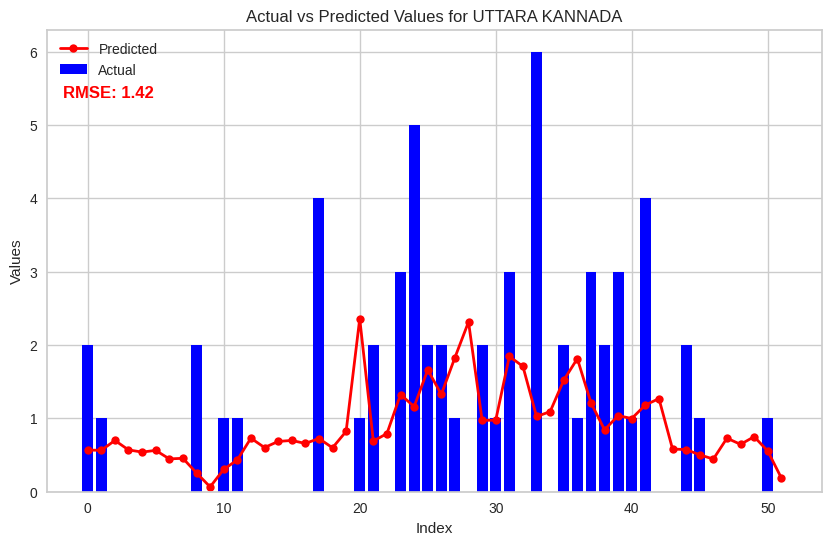

Analyzing District: VIJAYANAGAR


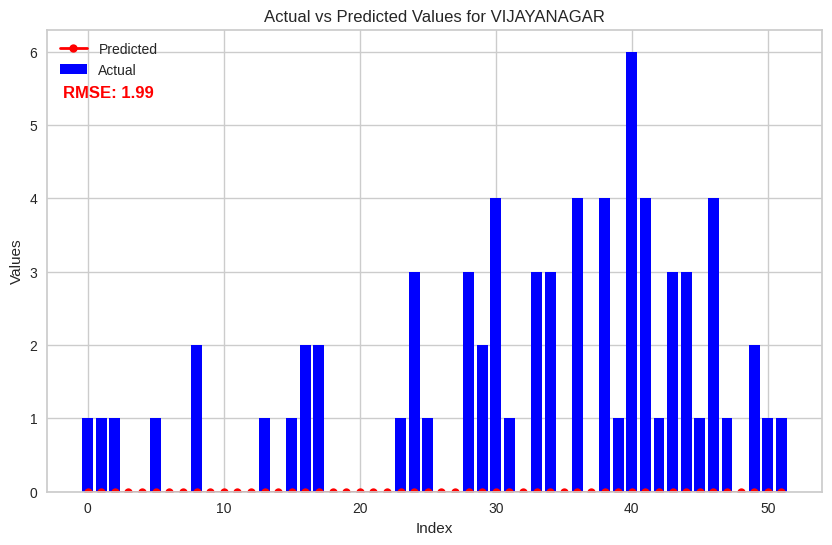

Analyzing District: VIJAYAPURA


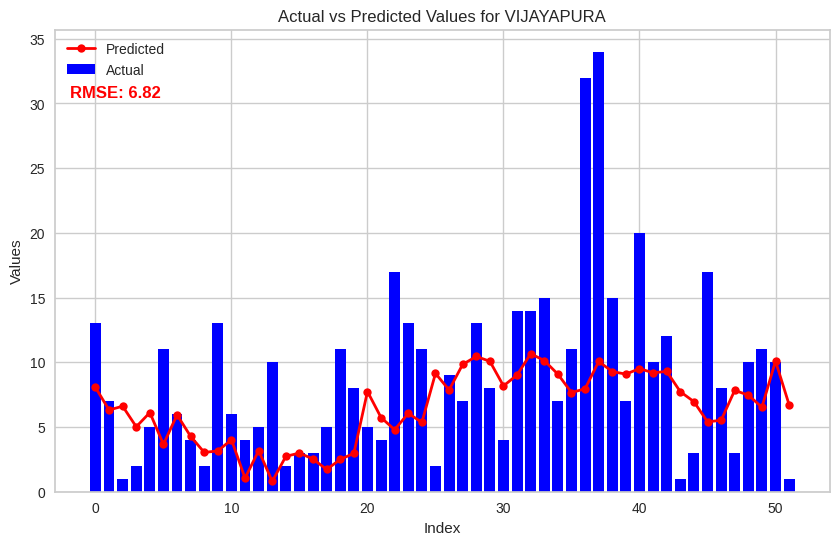

Analyzing District: YADGIR


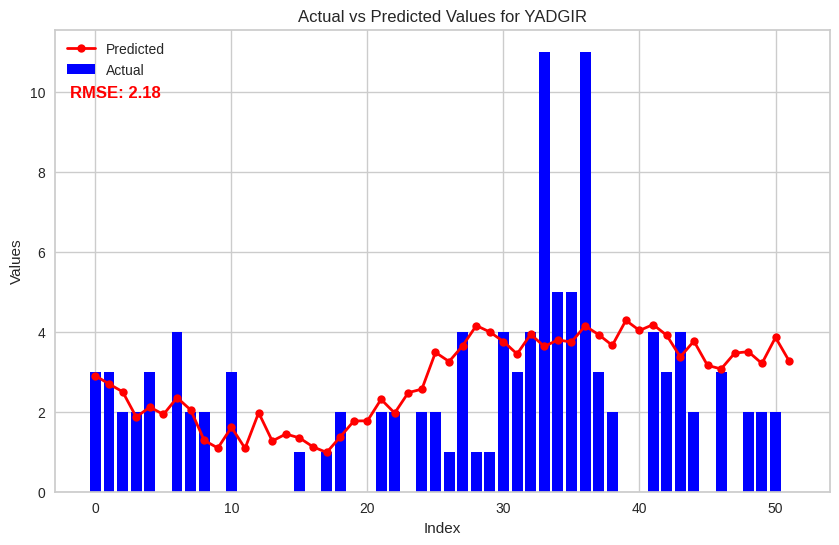

In [28]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2022)
df_2022 = district_analysis.analyze_districts()

In [29]:
from functools import reduce

# List of DataFrames to merge
dfs = [df_2017, df_2018, df_2019, df_2022]

# Function to merge two DataFrames on 'district' with suffixes
def merge_dfs(left, right):
    return pd.merge(left, right, on='district', suffixes=('', f"_{right.columns[-1][-4:]}"))

# Use reduce to iteratively merge all DataFrames
merged_df = reduce(merge_dfs, dfs)

merged_df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE   6.199998              Bad   3.405500              Bad   
1            BALLARI  10.297670              Bad   3.897859              Bad   
2           BELAGAVI   1.961705             Good   1.839380             Good   
3    BENGALURU RURAL   0.689137             Good   0.858532             Good   
4    BENGALURU URBAN   1.136340             Good   1.040838             Good   
5              BIDAR   5.103846              Bad   3.458398              Bad   
6    CHAMARAJANAGARA   2.770826              Bad   2.296853              Bad   
7    CHIKKABALLAPURA   2.514651              Bad   2.718098              Bad   
8     CHIKKAMAGALURU   6.626089              Bad   2.548258              Bad   
9        CHITRADURGA   8.797831              Bad   5.421539              Bad   
10  DAKSHINA KANNADA  11.047967              Bad  12.658664              Bad   
11         DAVANGERE  20.375842              Bad   4.150760              Bad   
12           DHARWAD   2.434322              Bad   2.220053              Bad   
13             GADAG   3.371426              Bad   2.438951              Bad   
14            HASSAN   3.413711              Bad   8.396512              Bad   
15            HAVERI   7.061718              Bad   2.885564              Bad   
16        KALABURAGI  28.686556              Bad  18.308189              Bad   
17            KODAGU   8.715199              Bad   1.567680             Good   
18             KOLAR   7.850756              Bad   3.567168              Bad   
19            KOPPAL   4.109411              Bad   4.015827              Bad   
20            MANDYA   2.516230              Bad   2.291092              Bad   
21            MYSURU  23.931196              Bad   6.658327              Bad   
22           RAICHUR   3.307177              Bad   1.991228             Good   
23        RAMANAGARA   8.328353              Bad   1.457101             Good   
24        SHIVAMOGGA  10.764567              Bad   5.593147              Bad   
25          TUMAKURU  15.575279              Bad   3.761121              Bad   
26             UDUPI   4.911946              Bad   5.354948              Bad   
27    UTTARA KANNADA   1.145098             Good   2.074142              Bad   
28       VIJAYANAGAR   0.287791             Good   0.256220             Good   
29        VIJAYAPURA   5.148024              Bad   5.628261              Bad   
30            YADGIR   2.279489              Bad   2.061248              Bad   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0    6.959106              Bad   5.072453              Bad  
1    4.195687              Bad   3.332246              Bad  
2    2.033278              Bad   7.353924              Bad  
3    1.279515             Good   2.902199              Bad  
4    3.808189              Bad   1.885973             Good  
5   10.207630              Bad   3.125378              Bad  
6   10.680992              Bad   5.750454              Bad  
7    5.742812              Bad   7.990216              Bad  
8    4.958358              Bad   3.413871              Bad  
9    7.156268              Bad   5.330778              Bad  
10  48.699195              Bad   8.573306              Bad  
11   5.586410              Bad   3.303467              Bad  
12   1.945807             Good   6.370403              Bad  
13   3.976143              Bad   2.387947              Bad  
14   7.952194              Bad   6.253992              Bad  
15   7.584647              Bad   3.801227              Bad  
16   7.816212              Bad   7.034336              Bad  
17   1.610412             Good   1.158811             Good  
18   4.756282              Bad   4.752617              Bad  
19   6.395128              Bad   2.732262              Bad  
20   2.085421              Bad   7.244606              Bad  
21   5.526891              Bad  12.777763              Bad  
22   1.360763             Good   1.753300       

In [30]:
merged_df = merged_df.round(2)
merged_df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE       6.20              Bad       3.41              Bad   
1            BALLARI      10.30              Bad       3.90              Bad   
2           BELAGAVI       1.96             Good       1.84             Good   
3    BENGALURU RURAL       0.69             Good       0.86             Good   
4    BENGALURU URBAN       1.14             Good       1.04             Good   
5              BIDAR       5.10              Bad       3.46              Bad   
6    CHAMARAJANAGARA       2.77              Bad       2.30              Bad   
7    CHIKKABALLAPURA       2.51              Bad       2.72              Bad   
8     CHIKKAMAGALURU       6.63              Bad       2.55              Bad   
9        CHITRADURGA       8.80              Bad       5.42              Bad   
10  DAKSHINA KANNADA      11.05              Bad      12.66              Bad   
11         DAVANGERE      20.38              Bad       4.15              Bad   
12           DHARWAD       2.43              Bad       2.22              Bad   
13             GADAG       3.37              Bad       2.44              Bad   
14            HASSAN       3.41              Bad       8.40              Bad   
15            HAVERI       7.06              Bad       2.89              Bad   
16        KALABURAGI      28.69              Bad      18.31              Bad   
17            KODAGU       8.72              Bad       1.57             Good   
18             KOLAR       7.85              Bad       3.57              Bad   
19            KOPPAL       4.11              Bad       4.02              Bad   
20            MANDYA       2.52              Bad       2.29              Bad   
21            MYSURU      23.93              Bad       6.66              Bad   
22           RAICHUR       3.31              Bad       1.99             Good   
23        RAMANAGARA       8.33              Bad       1.46             Good   
24        SHIVAMOGGA      10.76              Bad       5.59              Bad   
25          TUMAKURU      15.58              Bad       3.76              Bad   
26             UDUPI       4.91              Bad       5.35              Bad   
27    UTTARA KANNADA       1.15             Good       2.07              Bad   
28       VIJAYANAGAR       0.29             Good       0.26             Good   
29        VIJAYAPURA       5.15              Bad       5.63              Bad   
30            YADGIR       2.28              Bad       2.06              Bad   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0        6.96              Bad       5.07              Bad  
1        4.20              Bad       3.33              Bad  
2        2.03              Bad       7.35              Bad  
3        1.28             Good       2.90              Bad  
4        3.81              Bad       1.89             Good  
5       10.21              Bad       3.13              Bad  
6       10.68              Bad       5.75              Bad  
7        5.74              Bad       7.99              Bad  
8        4.96              Bad       3.41              Bad  
9        7.16              Bad       5.33              Bad  
10      48.70              Bad       8.57              Bad  
11       5.59              Bad       3.30              Bad  
12       1.95             Good       6.37              Bad  
13       3.98              Bad       2.39              Bad  
14       7.95              Bad       6.25              Bad  
15       7.58              Bad       3.80              Bad  
16       7.82              Bad       7.03              Bad  
17       1.61             Good       1.16             Good  
18       4.76              Bad       4.75              Bad  
19       6.40              Bad       2.73              Bad  
20       2.09              Bad       7.24              Bad  
21       5.53              Bad      12.78              Bad  
22       1.36             Good       1.75       

In [31]:
merged_df.to_csv('Ridge_performance.csv', index=False)

In [32]:
df = pd.read_csv("Ridge_performance.csv")
df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE       6.20              Bad       3.41              Bad   
1            BALLARI      10.30              Bad       3.90              Bad   
2           BELAGAVI       1.96             Good       1.84             Good   
3    BENGALURU RURAL       0.69             Good       0.86             Good   
4    BENGALURU URBAN       1.14             Good       1.04             Good   
5              BIDAR       5.10              Bad       3.46              Bad   
6    CHAMARAJANAGARA       2.77              Bad       2.30              Bad   
7    CHIKKABALLAPURA       2.51              Bad       2.72              Bad   
8     CHIKKAMAGALURU       6.63              Bad       2.55              Bad   
9        CHITRADURGA       8.80              Bad       5.42              Bad   
10  DAKSHINA KANNADA      11.05              Bad      12.66              Bad   
11         DAVANGERE      20.38              Bad       4.15              Bad   
12           DHARWAD       2.43              Bad       2.22              Bad   
13             GADAG       3.37              Bad       2.44              Bad   
14            HASSAN       3.41              Bad       8.40              Bad   
15            HAVERI       7.06              Bad       2.89              Bad   
16        KALABURAGI      28.69              Bad      18.31              Bad   
17            KODAGU       8.72              Bad       1.57             Good   
18             KOLAR       7.85              Bad       3.57              Bad   
19            KOPPAL       4.11              Bad       4.02              Bad   
20            MANDYA       2.52              Bad       2.29              Bad   
21            MYSURU      23.93              Bad       6.66              Bad   
22           RAICHUR       3.31              Bad       1.99             Good   
23        RAMANAGARA       8.33              Bad       1.46             Good   
24        SHIVAMOGGA      10.76              Bad       5.59              Bad   
25          TUMAKURU      15.58              Bad       3.76              Bad   
26             UDUPI       4.91              Bad       5.35              Bad   
27    UTTARA KANNADA       1.15             Good       2.07              Bad   
28       VIJAYANAGAR       0.29             Good       0.26             Good   
29        VIJAYAPURA       5.15              Bad       5.63              Bad   
30            YADGIR       2.28              Bad       2.06              Bad   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0        6.96              Bad       5.07              Bad  
1        4.20              Bad       3.33              Bad  
2        2.03              Bad       7.35              Bad  
3        1.28             Good       2.90              Bad  
4        3.81              Bad       1.89             Good  
5       10.21              Bad       3.13              Bad  
6       10.68              Bad       5.75              Bad  
7        5.74              Bad       7.99              Bad  
8        4.96              Bad       3.41              Bad  
9        7.16              Bad       5.33              Bad  
10      48.70              Bad       8.57              Bad  
11       5.59              Bad       3.30              Bad  
12       1.95             Good       6.37              Bad  
13       3.98              Bad       2.39              Bad  
14       7.95              Bad       6.25              Bad  
15       7.58              Bad       3.80              Bad  
16       7.82              Bad       7.03              Bad  
17       1.61             Good       1.16             Good  
18       4.76              Bad       4.75              Bad  
19       6.40              Bad       2.73              Bad  
20       2.09              Bad       7.24              Bad  
21       5.53              Bad      12.78              Bad  
22       1.36             Good       1.75       